<h1 align='center' style='color:purple'>Credit Card Fraud - Imbalanced Data Set</h1>

Winning kaggle notebook: https://www.kaggle.com/c/ieee-fraud-detection/discussion/111284  
https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600  

Try some of these ideas: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data  

**Use Case:** Credit Card Fraud Detection

    Compare different common algorithms, develop and optimize a new 2 sequential/consecutive model algorithm to see if this can give better results
    
**Author:** Donald Stierman - Senior Data Scientist

**Details:** Imbalanced data can cause issues with most Machine Learning Algorithms and Neural Networks. To alleviate this, I choose to down-sample the training data to use as the input dataset. After creating the down-sampled dataset, I ran this through several different common model algorithms, including a new modeling technique I developed specifically for imbalanced data. I got this idea after reading about some highly effective Healthcare screening solutions currently in use. I.E. Breast Cancer detection in women (see comments: below). If a mammogram comes back positive, we already know that there will be a lot of false positives (benign tumors, scars, etc). Usually the doctor will follow up with a 2nd test, such as biopsy. This will screen out the false positives leaving mostly true positives (cancerous tissue). This same idea can possibly be applied to credit care fraud. We want to catch all true cases of fraud (fraud prevention), to be compliant with government regulations, and additionally not create a huge workload of false cases to be investigated (cost control).

comments:

**Here are some different ways to explain the methodology used in the Healthcare use case:**

*1st test (high specificity) -> 2nd test (high sensitivity) -> Only treat cancerous tissue

*TN/(TN + FP) is high ~ 1    -> TP/(TP + FN) is high ~ 1    -> Find all Positive cases

*catch all possible cases/remove healthy patients -> remove all false flags -> high confidence in Positive result/few missed positives


This same methodology can be applied to Credit Card Fraud detection

Link to code repo at Github:

https://github.com/donaldstierman/imbalanced_data

**Models used:**<pre>
    Logistic Regression
    Random Forest
    Gradient Boosted Decision Trees
    Customized 2 Step Gradient Boosted Decision Trees
    Deep Neural Network
    1D Convolutional Neural Network
    AutoEncoder
</pre>
**Goal:** 
For this example, I chose 2 metrics to optimize, ROC/AUC and best "macro avg recall". I chose these because in the health care example, it is better to catch all cancer patients, even if it means more tests are performed. To compare the results, first objective is to find the best overall model (lowest mislabelled predictions), second is to find the model that has a low number of false negatives (faudulent transactions that are missed) without having too many false positives (genuine transactions that are needlessly investigated)
<pre>
    1) Compare the AUC to find the most robust model of the single step models. However, the value of this metric cannot be calculated directly on the 2 step model, so we need to use #2 below for final comparison
    2) Maximize the Sensitivity (higher priority) or reduce the number of False Negatives (FN/TP ratio) and maximize the Specificity (lower priority) to control the number of tests performed in the 2nd step. I.E. catch all the fraudulent transaction even if there are false flags (false positives).
</pre>
**Results:** The Customized 2 Step model has the best results overall, by only a slight margin. 
                          
                                AUC    Specificity/Sensitivity
                          
    Logistic Regression         .967    .95/.87
    Random Forest               .977    .97/.89  **best AUC**
    Gradient Boosted Tree       .976    .99/.84
    Customized 2 Step GB Trees  NA      .99/.93  **best overall**
    Deep Neural Network         .973    .95/.92  **2nd best overall**
    AutoEncoder                 .954    .88/.93    
    
    
Final Results: ROC Curve comparision

<!-- to save file to html for uploads, use this command: jupyter nbconvert --to html --template basic CreditCardFraud.ipynb -->

In [1]:
# Import Libraries

import datetime

import random as rn
rn.seed(1) # random
import numpy as np
#from numpy.random import seed
np.random.seed(7) # or 7
import tensorflow as tf
tf.random.set_seed(0) # tf

import pandas as pd
import os
import tempfile

import matplotlib as mpl                                                                                             
if os.environ.get('DISPLAY','') == '':                                                                               
    print('no display found. Using non-interactive Agg backend')                                                     
    mpl.use('Agg')                                                                    
    
import matplotlib.pyplot as plt
if (os.environ.get('TERM','') == 'xterm-color'): 
    %matplotlib inline
elif (os.environ.get('TERM','') == 'cygwin'):
    print("shell terminal found")
else: # 'cygwin'
    print("no terminal found")
    
import pandas_profiling as pp
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew, kurtosis, boxcox #for some statistics

from scipy.special import boxcox1p, inv_boxcox, inv_boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, Normalizer
from matplotlib import pyplot
import zipfile
import time

StartTime = datetime.datetime.now()


no display found. Using non-interactive Agg backend


In [2]:
class MyTimer():
    # usage:
    #with MyTimer():                            
    #    rf.fit(X_train, y_train)
    
    def __init__(self):
        self.start = time.time()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = end - self.start
        msg = 'The function took {time} seconds to complete'
        print(msg.format(time=runtime))

In [3]:
#print(os.environ)
print('TERM:', os.environ.get('TERM',''))

TERM: xterm-color


Always like to include a timer function to see where my code is running slow or taking most of the run time

In [4]:
class MyTimer():
    # usage:
    #with MyTimer():                            
    #    rf.fit(X_train, y_train)
    
    def __init__(self):
        self.start = time.time()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = end - self.start
        msg = 'The function took {time} seconds to complete'
        print(msg.format(time=runtime))

In [5]:
def CalcPct(df,title):
    unique_elements, counts_elements = np.unique(df, return_counts=True)
    calc_pct = round(counts_elements[1]/(counts_elements[0]+counts_elements[1]) * 100,6)
    print(title)
    print(np.asarray((unique_elements, counts_elements)))
    return calc_pct

In [6]:
colab = os.environ.get('COLAB_GPU', '10')
if (int(colab) == 0):
    from google.colab import drive
    drive.mount('/content/drive')  
else:
    print("colab_gpu not found")

colab_gpu not found


Setup to run on Google Colab and Kaggle platforms

In [7]:
# Check if Google Colab path exists
if os.path.exists("/content/drive/My Drive/MyDSNotebooks/Imbalanced_data/input/creditcardzip") :
    # Change the current working Directory    
    os.chdir("/content/drive/My Drive/MyDSNotebooks/Imbalanced_data/input/creditcardzip")
# else check if Kaggle/local path exists
elif os.path.exists("../input/creditcardzip") :
    # Change the current working Directory    
    os.chdir("../input/creditcardzip")
else:
    print("Can't change the Current Working Directory") 
print("Current Working Directory " , os.getcwd())

Current Working Directory  C:\DataScience\Repo\Imbalanced_data\CreditCardFraud\input\creditcardzip


In [8]:
verbose=0
# Load the Data Set
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
#off line data source for backup
#df = pd.read_csv('creditcard.csv')

Public Credit Card Dataset. This is financial data, and is considered to be sensitive so it is "encrypted" through the use of PCA to protect privacy. Only the Time and Dollar columns are intact after the "encryption"

Doing some initial data exploration

In [9]:
# Check the data, make sure it loaded okay
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [10]:
# Check the datatypes of the Data set 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
# Check the Uniqueness
df.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [12]:
# Check for missing data
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [13]:
# Check basic Statistics
# looks like StandardScaler was performed on this dataset, mean is close to 0 for all columns

df.describe(include ='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [14]:
# Check the Class Imbalance of the Data 

df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

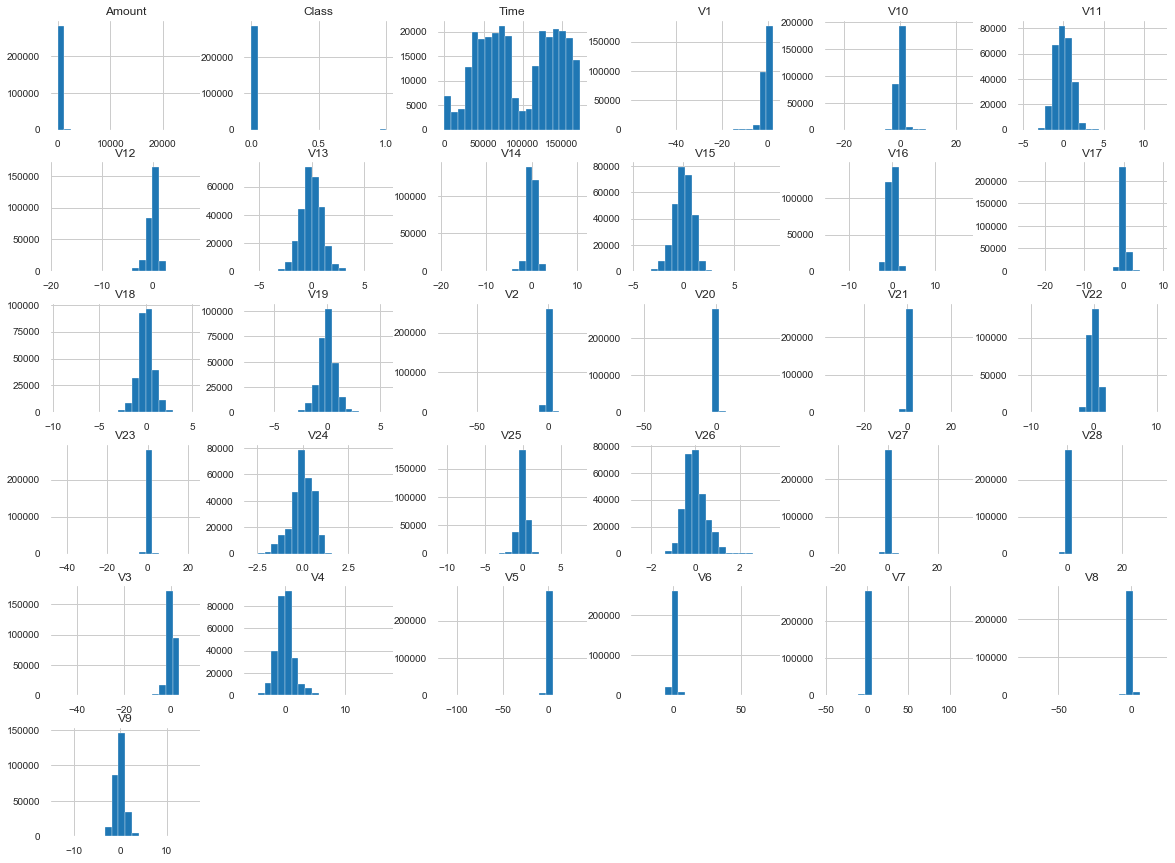

In [15]:
# Histograms of the features
# most of the data has a quasi-normal/gaussian distribution

df.hist(bins=20, figsize=(20,15))
plt.show()

Look at cross correlations between features. Most models will be fine with collinearity, but good to know this in any case. Most of my input is numerical, and my label is binary classification, so I can choose the Anova or Kendall's method. I will try the Kendall tau-b method first. This method will sort the 2 columns and compare if the X is always > or < Y. If so, the tau-b value will be 1.

Some key points to remember:
Kendall’s Tau: Calculations based on concordant and discordant pairs. Insensitive to error. P values are more accurate with smaller sample sizes. Good resource can be found here: https://online.stat.psu.edu/stat509/node/158/

This image shows which method you should choose based on your dataset:

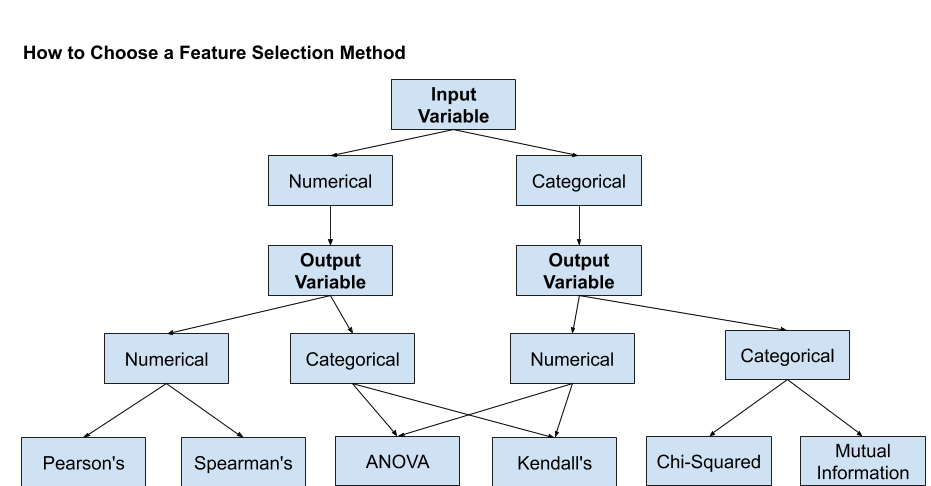

Text(0.5, 1.05, "Kendall'sCorrelation Matrix Full Data Set")

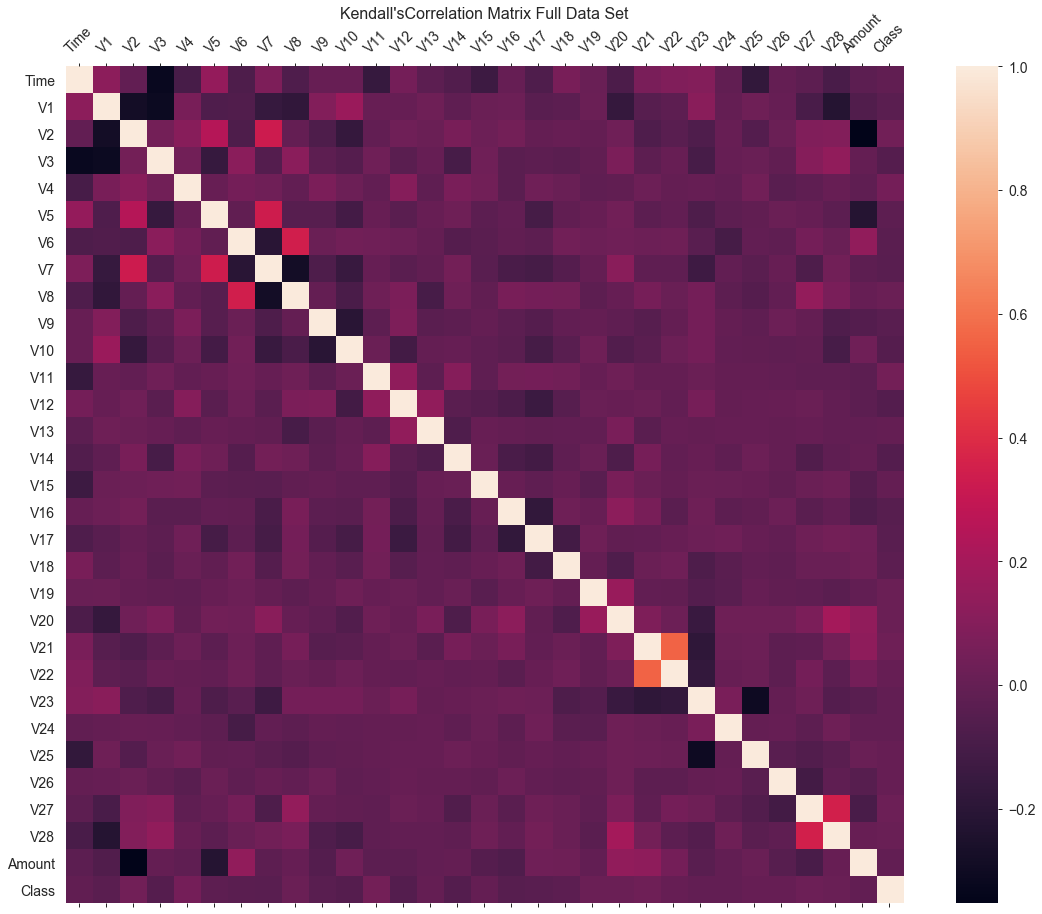

In [16]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(method='kendall'), fignum=f.number) # pearson or spearman are also available
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Kendall'sCorrelation Matrix Full Data Set", fontsize=16)

V21 and V22 show the highest tau-b score, will investigate this relationship later

In [17]:
#try some data cleansing, Amount has a few high values, so try using the log of that column instead.

temp_df = df.copy()
temp_df = temp_df.drop(['Time'], axis=1)
temp_df['Log_Amount'] = np.log(temp_df.pop('Amount')+0.001)
df = temp_df.copy()

In [18]:
from scipy.special import boxcox1p
lam = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1,2,3]
for i in lam:
    print("lam:", i)
    X = df.loc[:, df.columns != 'Class']
    y = df.loc[:, df.columns == 'Class']
    norm = MinMaxScaler().fit(X)
    X = pd.DataFrame(norm.transform(X), index=X.index, columns=X.columns)
    numeric_feats = X.dtypes[X.dtypes != "object"].index
    skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 2]
    skewness = skewness[skewness.Skew == skewness.Skew]
    print("Pre: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
    print("Pre", abs(skewness.Skew).mean())
    skewed_features = skewness.index
    lam_f = 0.0
    for feat in skewed_features:
        X[feat] = boxcox1p(X[feat], i)
    numeric_feats = X.dtypes[X.dtypes != "object"].index
    skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 2]
    skewness = skewness[skewness.Skew == skewness.Skew]
    print("Post: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
    print("Post", abs(skewness.Skew).mean())

lam: 0
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.924619556314968
lam: 0.1
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.752674910071598
lam: 0.2
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.591619281099101
lam: 0.3
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.4408440384190175
lam: 0.4
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 11 skewed numerical features to Box Cox transform
Post 5.019947162619655
lam: 0.5
Pre: There are 12 skewed numerical features to Box Cox transfo

In [19]:
from scipy.special import boxcox1p
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
numeric_feats = X.dtypes[X.dtypes != "object"].index
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 1.0]
skewness = skewness[skewness.Skew == skewness.Skew]
print("Pre: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print("Pre", abs(skewness.Skew).mean())
skewed_features = skewness.index
pt = PowerTransformer(method='yeo-johnson').fit(X)
X = pd.DataFrame(pt.transform(X), index=X.index, columns=X.columns)
numeric_feats = X.dtypes[X.dtypes != "object"].index
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 1.0]
skewness = skewness[skewness.Skew == skewness.Skew]
print("Post: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print("Post", abs(skewness.Skew).mean())

Pre: There are 17 skewed numerical features to Box Cox transform
Pre 3.514581911418132
Post: There are 8 skewed numerical features to Box Cox transform
Post 1.977383868458546


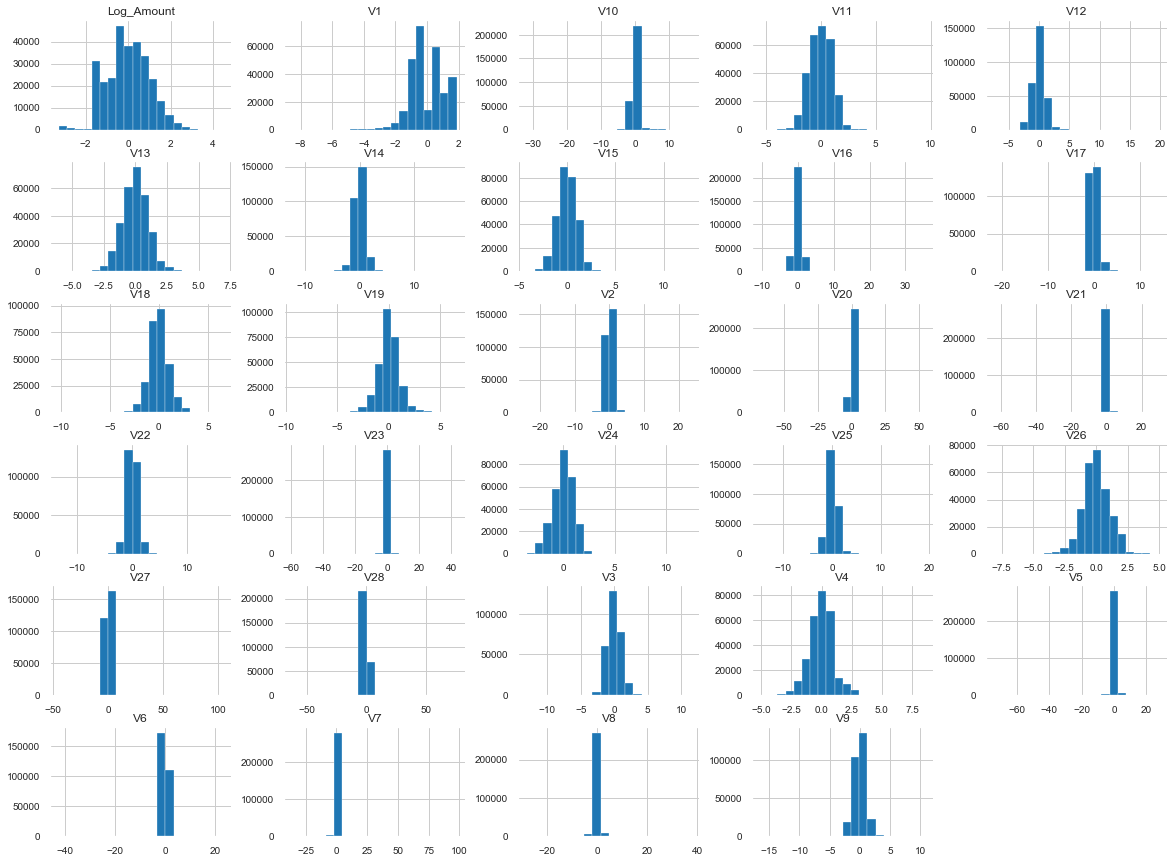

In [20]:
X.hist(bins=20, figsize=(20,15))
plt.show()

In [21]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
V27,3.465013
V7,2.594561
V8,2.297578
V28,1.069187
V2,0.334850
V12,0.158932
V16,0.137436
V24,0.112492
V14,0.105965
V25,0.077895


Need to normalize the data before using boxcox or log transforms as they don't work on negative and 0 values

In [22]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
norm = MinMaxScaler().fit(X)
X = pd.DataFrame(norm.transform(X), index=X.index, columns=X.columns)

Pre-transform skew

In [23]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in all numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in all numerical features: 



,Skew
V28,11.192032
V21,3.592972
V7,2.553894
V6,1.826571
V10,1.187134
V4,0.676289
V26,0.576690
V9,0.554677
V11,0.356504
V19,0.109191


In [24]:
skewness = skewness[abs(skewness) > 0.75]
skewness = skewness[skewness.Skew == skewness.Skew]
print("There are {} highly skewed numerical features to Box Cox transform".format(skewness.shape[0]))


There are 18 highly skewed numerical features to Box Cox transform


In [25]:
skewness

,Skew
V28,11.192032
V21,3.592972
V7,2.553894
V6,1.826571
V10,1.187134
Log_Amount,-0.834481
V16,-1.100960
V27,-1.170203
V14,-1.995165
V20,-2.037145


In [26]:
abs(skewness.Skew).mean()

3.3656874002907333

In [27]:
from scipy.special import boxcox1p
skewed_features = skewness.index

lam_f = 0.0
for feat in skewed_features:
    X[feat] = boxcox1p(X[feat], lam_f)

Post-transform skew

In [28]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
V28,6.241873
V6,1.359141
V21,1.251583
V4,0.676289
V26,0.576690
V9,0.554677
V10,0.363269
V11,0.356504
V19,0.109191
V13,0.065233


In [29]:
skewness = skewness[abs(skewness) > 0.75]
skewness = skewness[skewness.Skew == skewness.Skew]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 16 skewed numerical features to Box Cox transform


In [30]:
skewness

,Skew
V28,6.241873
V6,1.359141
V21,1.251583
Log_Amount,-1.430289
V16,-1.493943
V14,-2.828641
V27,-2.878341
V3,-2.936423
V12,-3.084228
V1,-4.104152


In [31]:
abs(skewness.Skew).mean()

4.4055082951185405

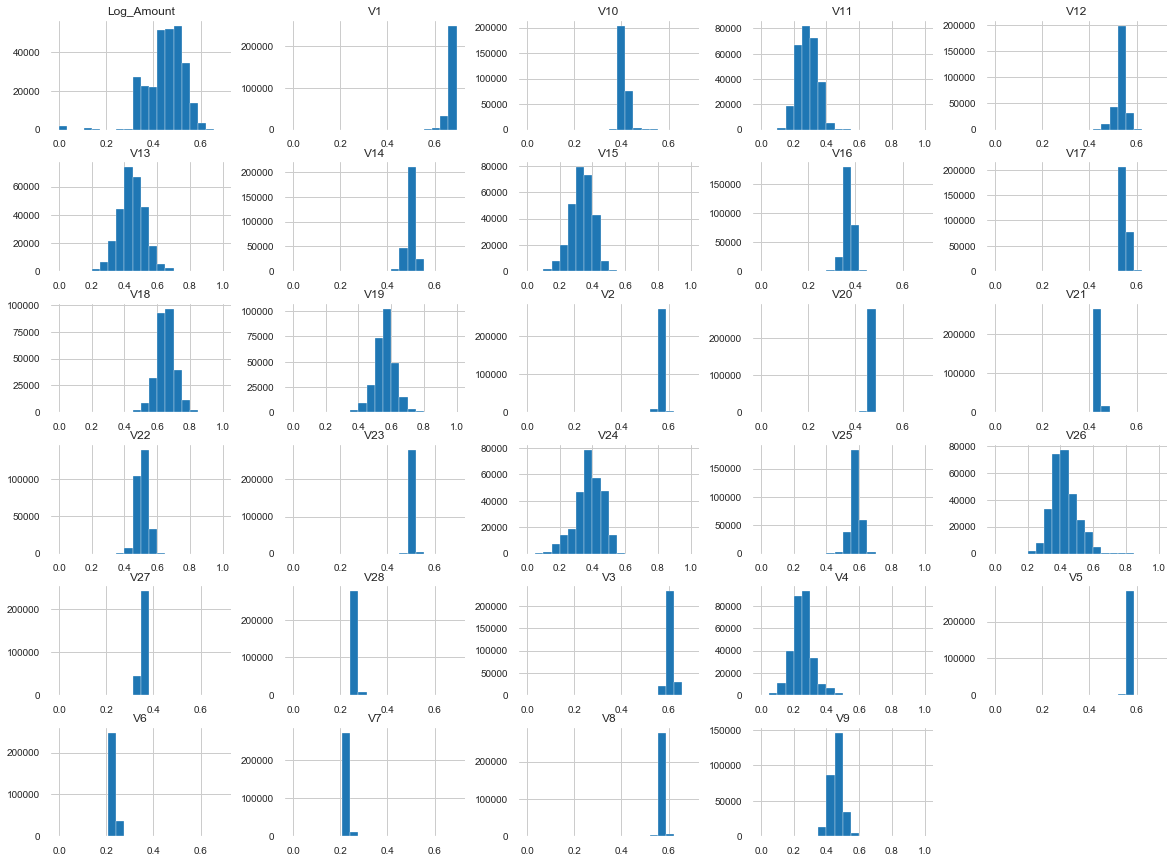

In [32]:
X.hist(bins=20, figsize=(20,15))
plt.show()

so far the MinMaxScaler, boxcox1p and log1p transforms make the data more skewed...
just utilize the PowerTransformer instead, with yeo-johnson as there are many negative values

Divide the dataset into features and labels and then into Train, Test and Validate datasets

In [33]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']

# divide full data into features and label
spl1 = 0.36
spl2 = 0.44

OrigPct = CalcPct(y,"Original")

strat = True
if (strat == True):
    stratify=y['Class']
else:
    stratify="None"
# create train, test and validate datasets

# first split original into Train and Test+Val
X_train, X_test1, y_train, y_test1 = train_test_split(X,y, test_size = spl1, random_state = None, shuffle=True, stratify=stratify)
# then split Test+Val into Test and Validate
# Validate will only be used in the 2 Model system (explained below)
X_test, X_val, y_test, y_val = train_test_split(X_test1,y_test1, test_size = spl2, random_state = None, shuffle=True)
y_train_orig = y_train.copy(deep=True)

Original
[[     0      1]
 [284315    492]]


In [34]:
type(y_test)

pandas.core.frame.DataFrame

The correct way to transform, fit the train data and transform train, test and val data based on the fit  
This does not have any effect on the performance of the model. Mean Specificity and Sensitivity are unchanged. Tested ~ 20 iterations

In [35]:
pt_tran = 0
if (pt_tran == 1):
    pt = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
    X_train = pd.DataFrame(pt.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test  = pd.DataFrame(pt.transform(X_test), index=X_test.index, columns=X_test.columns)
    X_val   = pd.DataFrame(pt.transform(X_val), index=X_val.index, columns=X_val.columns)

In [36]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log_Amount
3995,-3.061576,-1.609474,1.266768,-0.188387,-1.378141,0.094377,0.527057,0.372759,1.746894,-1.524352,...,-0.107001,-0.298469,-0.583340,-0.388332,0.402433,-0.228393,0.730564,0.468322,-0.519314,6.080324
206839,2.016664,-0.295829,-1.274823,0.576648,0.064849,-0.401485,-0.033828,-0.151370,0.911290,0.035809,...,-0.178484,0.059041,0.371626,0.049808,0.635122,0.156468,0.431767,-0.058829,-0.056319,3.321829
203290,1.906775,-0.266594,-1.298421,0.046871,0.712519,0.859223,-0.176517,0.284621,0.292143,0.098817,...,-0.301310,-0.173312,-0.285657,0.374574,-1.414964,-0.511378,0.298838,-0.021495,-0.085039,0.683602
49000,1.278589,-0.407273,0.043719,-0.416042,-0.659118,-0.582916,-0.442022,-0.109653,-0.743877,0.042458,...,0.174561,-0.023581,-0.052466,-0.020906,0.034297,0.415913,-0.277985,0.036688,0.042371,3.849530
32273,-1.029929,0.317218,1.883790,1.263336,0.941544,0.603159,0.092656,0.434794,-0.747081,-0.243852,...,0.151384,0.083407,0.271616,-0.186581,-0.267942,0.362197,-0.118816,0.095750,0.070233,2.562716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242196,0.046289,1.073534,-2.870576,-1.401650,3.394685,2.768640,0.742270,0.769076,-0.804768,-0.658705,...,-0.090782,0.115482,0.291256,-0.088442,0.660860,-0.386690,0.657981,-0.384068,-0.221145,2.854802
222581,-6.903785,7.074879,-7.444233,-0.770873,-2.308480,0.999301,-8.083382,-12.598876,-2.160735,-2.656812,...,3.799474,-6.928952,3.806711,1.815396,0.640756,-1.011809,0.586348,-0.016609,0.532837,0.693647
67784,1.343714,-0.492742,0.681219,-0.727428,-1.171129,-0.827195,-0.651450,-0.054960,-1.027848,0.775199,...,0.073751,-0.031261,-0.253333,0.145841,0.520776,0.172120,-0.510307,0.006198,0.014934,2.432824
241875,2.156093,0.468552,-2.764556,0.312540,1.167886,-1.356995,0.843973,-0.535594,-0.186071,-0.308615,...,-0.118768,0.038380,0.241599,-0.040463,0.452151,0.410147,0.665515,-0.106396,-0.050652,0.399447


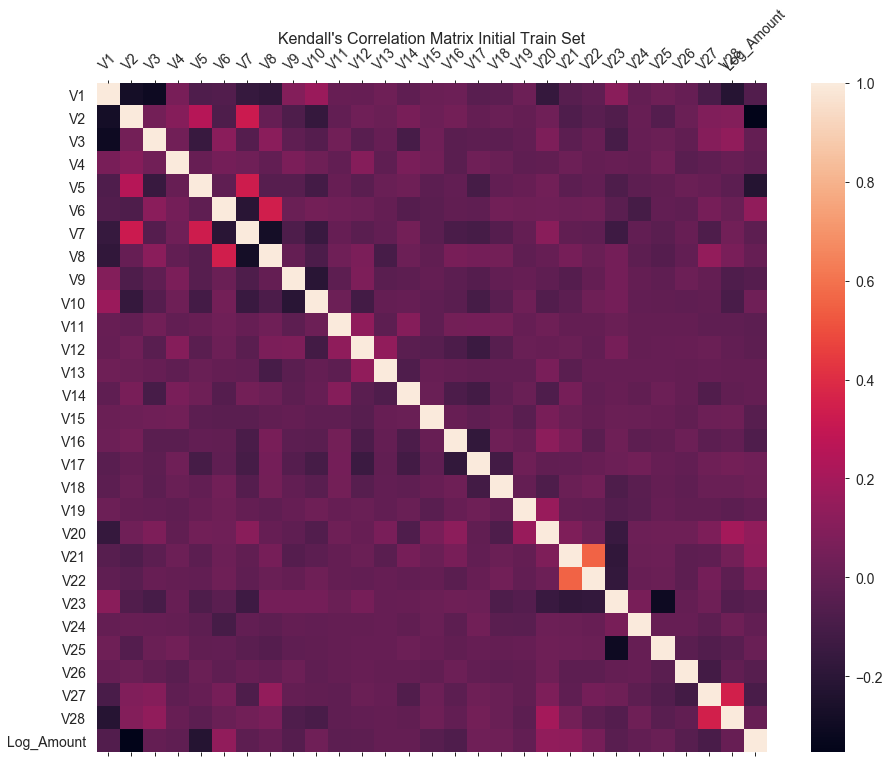

In [37]:
f = plt.figure(figsize=(16, 12))
plt.matshow(X_train.corr(method='kendall'), fignum=f.number) # pearson or spearman are also available
plt.xticks(range(X_train.shape[1]), X_train.columns, fontsize=14, rotation=45)
plt.yticks(range(X_train.shape[1]), X_train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Kendall's Correlation Matrix Initial Train Set", fontsize=16)
plt.show()

In [38]:
# prepare data for model, need to do this normalization and clipping separately for X_train, X_test and X_val 
# to avoid any contamination between Train and Test/Validate datasets
a='''
sc = StandardScaler()

X_train2 = pd.DataFrame(sc.fit_transform(X_train),columns = X_train.columns)
X_test2 = pd.DataFrame(sc.transform(X_test),columns = X_test.columns)
X_val2 = pd.DataFrame(sc.transform(X_val),columns = X_val.columns)


#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

# handle any extreme fliers, set to 5 or -5
X_train2 = np.clip(X_train2, -5, 5)
X_test2 = np.clip(X_test2, -5, 5)
X_val2 = np.clip(X_val2, -5, 5)
'''

# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

save_data = 1
if (save_data == 1):
    df1 = train_df.copy()
    df1.to_csv('CCFraudTrain.csv', index=False)  
    df2 = test_df.copy()
    df2.to_csv('CCFraudTest.csv', index=False) 
    df3 = val_df.copy()
    df3.to_csv('CCFraudVal.csv', index=False) 

In [39]:
train_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log_Amount
108985,-1.545020,1.234436,1.741641,0.133185,0.352848,-0.405230,0.788977,-2.052176,-0.480273,-0.260420,...,1.556598,-0.121536,-0.339893,0.413720,0.706673,-0.379899,-0.088866,-0.132888,0,4.317501
247091,0.066255,-0.266618,-1.170279,-0.400821,2.222208,-0.702468,0.359574,-0.166717,0.599190,-0.693427,...,-0.019310,0.129801,0.250602,-1.510295,-1.879696,-0.333126,0.190097,0.164814,0,2.302685
50715,1.108832,-0.249155,0.355665,0.780999,-0.505651,-0.323854,-0.057473,-0.051546,0.639521,-0.229119,...,-0.292766,-0.876909,-0.051692,-0.134225,0.362026,0.207093,-0.034323,0.024233,0,4.442545
159806,2.127204,-0.168670,-1.765445,0.043647,0.371432,-0.581626,0.035169,-0.154751,1.056352,-0.047981,...,0.200812,0.647014,-0.048619,0.061377,0.383932,-0.406974,-0.008439,-0.057353,0,0.001000
133759,1.086299,-0.289682,1.299472,0.808759,-0.886994,0.486093,-0.769412,0.347113,1.061342,-0.402575,...,-0.141897,-0.070204,0.167164,0.132025,0.053391,0.449464,0.040647,0.017811,0,0.001000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23820,-1.260058,-0.091182,1.337529,0.129409,0.566871,1.492429,0.693072,0.566414,-0.116552,-0.788239,...,0.060569,0.186875,0.438295,-0.952140,-0.245843,0.362672,0.318726,0.178101,0,5.166276
110650,-0.399338,0.753100,2.312298,0.957786,-0.299136,0.333897,0.081362,0.174102,0.126442,-0.518401,...,0.007572,0.246440,-0.224454,-0.099531,-0.096308,-0.322140,0.188290,0.136831,0,2.301685
116547,0.771667,-1.106273,1.007343,0.354752,-1.533803,-0.140059,-0.559374,0.195165,1.068525,-0.344313,...,-0.061118,-0.452108,-0.068708,0.590966,-0.029585,0.895113,-0.081395,0.038304,0,5.327881
145816,-0.024950,1.554469,1.587469,4.108145,1.293879,1.075116,1.097120,-0.314708,-2.246136,2.063348,...,-0.231031,-0.369423,-0.109470,0.730357,-0.533616,-0.011651,-0.314704,-0.284703,0,-0.247180


In [40]:
if (save_data == 1):
    #train_df = pd.read_csv('CCFraudTrain.csv')                                                                         
    #test_df = pd.read_csv('CCFraudTest.csv')  
    #val_df = pd.read_csv('CCFraudVal.csv')  
    train_df = pd.read_csv('C:\DataScience\Repo\Imbalanced_data\CreditCardFraud\working\Imb_Train.csv')                                                                         
    test_df = pd.read_csv('C:\DataScience\Repo\Imbalanced_data\CreditCardFraud\working\Imb_Test.csv')  
    val_df = pd.read_csv('C:\DataScience\Repo\Imbalanced_data\CreditCardFraud\working\Imb_Val.csv')     

In [41]:
train_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log_Amount
0,2.064427,-0.678267,-1.182544,-0.294405,-0.523526,-1.078600,-0.026953,-0.457781,-0.677000,0.780291,...,-0.566120,-1.055463,0.291850,-0.003475,-0.294199,0.382397,-0.058117,-0.047036,0,4.171321
1,-0.033203,0.168765,1.629519,-0.671260,-0.868145,-0.560606,-0.053254,-0.068050,2.056705,-1.389574,...,-0.015896,0.270603,0.260711,0.371482,-0.842842,0.033546,0.117233,0.096070,0,4.098519
2,-0.692701,-0.197217,-0.318752,-2.381848,2.305245,3.879317,0.393759,1.046436,0.349419,-1.307709,...,0.406192,0.826120,0.188641,0.682871,-0.306534,-0.505867,0.152254,0.198379,0,4.990439
3,-1.595856,1.641527,1.129989,1.418422,0.937196,-0.453797,0.866243,0.241720,-1.897454,-0.078866,...,0.130214,0.129917,-0.522210,0.119955,0.648366,-0.004395,-0.311915,-0.123065,0,-0.209487
4,0.035630,0.906604,-0.611477,-0.767546,1.655406,0.769441,0.764074,0.305509,-0.095892,-0.979482,...,-0.273291,-0.514839,0.145211,-0.655643,-0.586476,0.219765,0.273780,0.071852,0,1.502075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182271,0.185683,-0.558693,-1.153973,-3.707375,1.969483,3.312250,-0.586515,0.743458,-2.395772,1.087843,...,0.159357,0.728045,-0.198830,0.714435,0.000211,0.040831,-0.052693,0.031139,0,1.386544
182272,2.017708,-0.185327,-0.514893,0.264077,-0.165506,-0.120488,-0.402304,-0.068663,1.038459,-0.217843,...,-0.187389,-0.342840,0.350853,0.472414,-0.312576,-0.644817,0.040640,-0.023218,0,1.938886
182273,2.012698,-0.357137,-3.095284,-0.502415,2.706312,3.171426,-0.094055,0.655017,0.205702,0.139086,...,-0.013822,-0.008707,0.084168,0.752532,0.242453,0.397578,-0.069485,-0.075736,0,3.507088
182274,1.109150,-0.557604,1.345304,0.608542,-1.200660,0.475866,-0.979813,0.245749,-0.833857,0.792138,...,-0.259732,-0.157366,0.086047,0.205356,0.167783,-0.403980,0.106706,0.040180,0,3.713596


In [42]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [43]:
class_names=[0,1] # name  of classes 1=fraudulent transaction

y_val['Class'].value_counts()

TrainPct = CalcPct(y_train,"Train")
TestPct = CalcPct(y_test,"Test")
ValPct = CalcPct(y_val,"Val")
zeros, ones = np.bincount(y_train['Class'])

Train
[[     0      1]
 [181961    315]]
Test
[[    0     1]
 [57312   105]]
Val
[[    0     1]
 [45042    72]]


Investigate the high tau-b value between V21 and V22

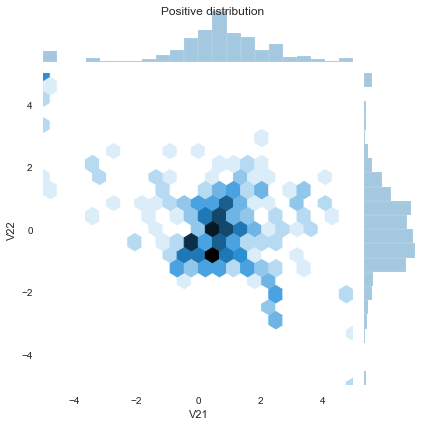

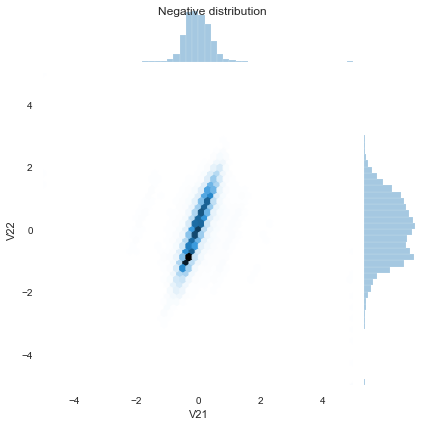

In [44]:
# Form np arrays of labels and features for jointplot charts

pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = X.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = X.columns)
sns.jointplot(pos_df['V21'], pos_df['V22'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")
sns.jointplot(neg_df['V21'], neg_df['V22'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

V21 shows a slight one-sided tail, however Kendall's correlation test is good to use here as it is a non-parametric test and can handle non-gaussian distributions like this

For a imbalanced sampling strategy, I will be using undersampling in my project as i think this is the best approach for this type of data

In [45]:
# find the number of minority (value=1) samples in our train set so we can down-sample our majority to it
yes = len(y_train[y_train['Class'] ==1])

# retrieve the indices of the minority and majority samples 
yes_ind = y_train[y_train['Class'] == 1].index
no_ind = y_train[y_train['Class'] == 0].index

# random sample the majority indices based on the amount of 
# minority samples
new_no_ind = np.random.choice(no_ind, yes, replace = False)

# merge the two indices together
undersample_ind = np.concatenate([new_no_ind, yes_ind])

# get undersampled dataframe from the merged indices of the train dataset
X_train = X_train.loc[undersample_ind]
y_train = y_train.loc[undersample_ind]

y_train = np.array(y_train).flatten()

In [46]:
type(y_train)

numpy.ndarray

Create some calculation and visualization functions to show the results

In [47]:
def visualize(Actual, Pred, Algo):
    #Confusion Matrix
    cnf_matrix=metrics.confusion_matrix(Actual, Pred) #

    #Visualize confusion matrix using heat map

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+Algo, y=1.1) 
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [48]:
def display_metrics(model_name, train_features, test_features, train_label, test_label, pred, algo):
    model_probs = model_name.predict_proba(test_features)
    n = model_name.predict_proba(test_features).shape[1]-1
    model_probs = model_probs[:, n]
    try:
        print(model_name.score(test_features, test_label)) 
        print("Accuracy score (training): {0:.3f}".format(model_name.score(train_features, train_label))) 
        print("Accuracy score (validation): {0:.3f}".format(model_name.score(test_features, test_label))) 
    except Exception as e:
        print("error")  
    try:
        print(pd.Series(model_name.feature_importances_, index=train_features.columns[:]).nlargest(10).plot(kind='barh')) 
    except Exception as e:
        print("error") 
    print("Confusion Matrix:")
    tn, fp, fn, tp = confusion_matrix(test_label, pred).ravel()
    total = tn+ fp+ fn+ tp 
    print("false positive pct:",(fp/total)*100) 
    print("tn", " fp", " fn", " tp") 
    print(tn, fp, fn, tp) 
    print(confusion_matrix(test_label, pred)) 
    print("Classification Report") 
    print(classification_report(test_label, pred))
    print("Specificity =", tn/(tn+fp))
    print("Sensitivity =", tp/(tp+fn))
    print('SS Avg =', ( (tn/(tn+fp)) + (tp/(tp+fn)))/2)
    if (type(test_label) != np.ndarray):
        y = np.reshape(test_label.to_numpy(), -1)
    else:
        y = test_label
    fpr, tpr, thresholds = metrics.roc_curve(y, model_probs, pos_label=1)
    cm_results.append([algo, tn, fp, fn, tp])
    cr_results.append([algo, classification_report(test_label, pred)])
    roc.append([algo, fpr, tpr, thresholds])
    # AUC score should be (Sensitivity+Specificity)/2
    print(algo + ':TEST | AUC Score: ' + str( round(metrics.auc(fpr, tpr),3 )))
    return tn, fp, fn, tp

In [49]:
def auc_roc_metrics(model, test_features, test_labels, algo): # model object, features, actual labels, name of algorithm
    # useful for imbalanced data
    ns_probs = [0 for _ in range(len(test_labels))]
    # predict probabilities
    model_probs = model.predict_proba(test_features)
    # keep probabilities for the positive outcome only
    n = model.predict_proba(test_features).shape[1]-1
    model_probs = model_probs[:, n]  
    model_auc = auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo) 
    return model_auc

In [50]:
def auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo):
    
    # calculate scores
    ns_auc = roc_auc_score(test_labels, ns_probs) # no skill
    model_auc = round(roc_auc_score(test_labels, model_probs), 3)

    # summarize scores
    print('%10s : ROC AUC=%.3f' % ('No Skill',ns_auc))
    print('%10s : ROC AUC=%.3f' % (algo,model_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_labels, ns_probs)
    # NameError: name 'ns_probs' is not defined
    model_fpr, model_tpr, _ = roc_curve(test_labels, model_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(model_fpr, model_tpr, marker='.', label='%s (area = %0.2f)' % (algo, model_auc))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    pyplot.title('Receiver Operating Characteristic curve')
    # show the plot
    pyplot.show()
    return model_auc

In [51]:
# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [52]:
def prediction_cutoff(model, test_features, cutoff):
    model.predict_proba(test_features)
    # to get the probability in each class, 
    # for example, first column is probability of y=0 and second column is probability of y=1.

    # the probability of being y=1
    prob1=model.predict_proba(test_features)[:,1]
    predicted=[1 if i > cutoff else 0 for i in prob1]
    return predicted

In [53]:
metrics_results = {}
roc = []
cm_results = []
cr_results = []

In [54]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log_Amount
124918,-0.885037,0.707661,1.529434,-1.308083,-0.061934,-0.876628,0.745586,-0.146148,-0.221411,-0.701461,...,-0.170364,0.160618,0.360851,-0.168280,0.501213,-0.223056,1.281184,-0.291422,0.091733,3.218516
23839,-0.755619,0.191011,2.182344,-0.906779,-0.524621,-0.846251,0.097810,0.140650,0.300621,-0.824199,...,-0.081698,0.236096,0.454443,-0.120442,0.415337,-0.221997,0.959398,-0.008966,0.100523,3.399563
62495,1.168147,-0.787377,1.745326,1.128224,-1.702524,0.518416,-1.239400,0.208084,0.408201,0.381259,...,-0.464364,-0.469771,-0.378405,-0.018810,0.419654,0.466558,-0.283249,0.132419,0.048380,3.401231
206858,1.973981,0.172996,-3.654877,0.475596,3.223988,3.065788,0.115631,0.658640,-0.016908,-0.338487,...,-0.130878,-0.027975,-0.007918,-0.010900,0.579722,0.504343,-0.473229,0.015757,-0.031521,3.355188
225667,-0.461472,1.472001,-1.171245,-0.724878,1.345398,-0.845615,1.694371,-0.302476,-0.692810,-0.316596,...,0.169858,0.083516,0.532176,-0.296034,0.761866,0.395550,0.620586,0.212566,0.151520,3.756795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149874,-1.662937,3.253892,-7.040485,2.266456,-4.177649,-0.746925,-0.248337,1.091157,-0.307137,-5.567947,...,-0.842178,0.450381,0.521162,0.308325,-0.318012,-1.255362,-0.691963,0.264878,-0.130445,6.398147
9252,-5.454362,8.287421,-12.752811,8.594342,-3.106002,-3.179949,-9.252794,4.245062,-6.329801,-13.136698,...,1.305862,1.846165,-0.267172,-0.310804,-1.201685,1.352176,0.608425,1.574715,0.808725,0.001000
178208,-5.904921,4.439911,-8.631802,7.788684,-4.989580,-1.200144,-7.674060,4.125761,-5.315778,-4.891156,...,-0.505608,1.775030,1.266441,-0.199410,0.014960,-0.000019,0.544210,-1.167566,-1.206354,3.817954
42590,-5.932778,4.571743,-9.427247,6.577056,-6.115218,-3.661798,-10.894079,3.709210,-5.859524,-12.981619,...,1.191078,2.014272,-0.167417,0.049968,0.384430,-0.077884,0.565493,1.792012,0.371007,1.667895


run Logistic Regression model first

In [55]:
lr = LogisticRegression()
#lr = LogisticRegression(solver='lbfgs')

lr.fit(X_train, y_train)
#lr_Pred = lr.predict(X_test)
# or
lr_Pred = prediction_cutoff(lr, X_test, 0.5) # 0.5 is the default cutoff for a logistic regression test

Show the results of this model

0.9635473814375534
0.9635473814375534
Accuracy score (training): 0.957
Accuracy score (validation): 0.964
error
Confusion Matrix:
false positive pct: 3.631328700559068
tn  fp  fn  tp
55227 2085 8 97
[[55227  2085]
 [    8    97]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     57312
           1       0.04      0.92      0.08       105

    accuracy                           0.96     57417
   macro avg       0.52      0.94      0.53     57417
weighted avg       1.00      0.96      0.98     57417

Specificity = 0.9636201842546064
Sensitivity = 0.9238095238095239
SS Avg = 0.9437148540320651
LR:TEST | AUC Score: 0.967


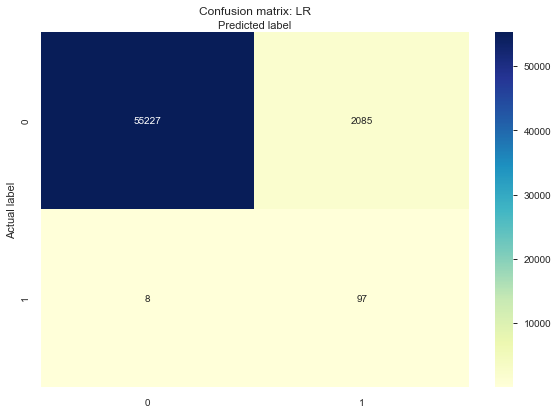

  No Skill : ROC AUC=0.500
        LR : ROC AUC=0.967


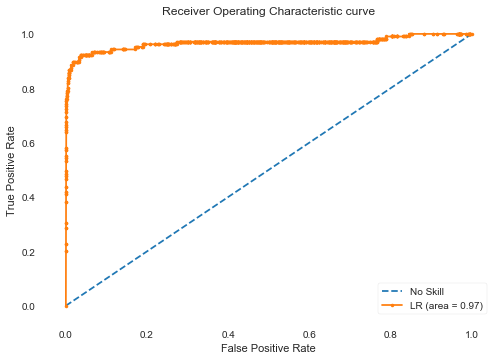

In [56]:
print(metrics.accuracy_score(y_test, lr_Pred))
tn, fp, fn, tp = display_metrics(lr, X_train, X_test, y_train, y_test, lr_Pred, 'LR')
visualize(y_test, lr_Pred, 'LR') # actual labels vs predicted labels
lr_auc = auc_roc_metrics(lr, X_test, y_test, 'LR')
metrics_results['lr'] = lr_auc

Logistic: f1=0.085 auc=0.484


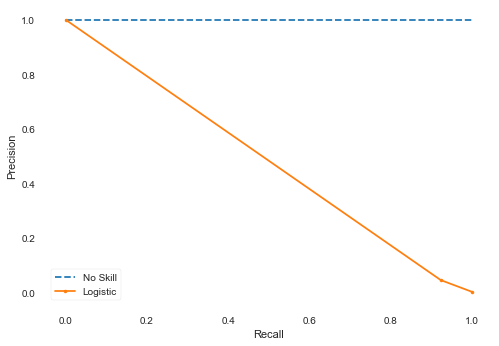

In [57]:
# useful for unbalanced data, maybe include later in metrics summary for all models

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_Pred)
lr_f1, lr_auc = f1_score(y_test, lr_Pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Next try the Random Forest model

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     57312
           1       0.06      0.91      0.11       105

    accuracy                           0.97     57417
   macro avg       0.53      0.94      0.55     57417
weighted avg       1.00      0.97      0.98     57417

0.9720466064057683
Accuracy score (training): 1.000
Accuracy score (validation): 0.972
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 2.779664559276869
tn  fp  fn  tp
55716 1596 9 96
[[55716  1596]
 [    9    96]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     57312
           1       0.06      0.91      0.11       105

    accuracy                           0.97     57417
   macro avg       0.53      0.94      0.55     57417
weighted avg       1.00      0.97      0.98     57417

Specificity = 0.9721524288107203
Sensitivity = 0.9142857142857143
SS Avg = 0.94321

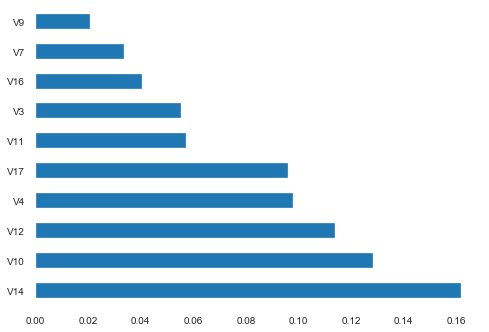

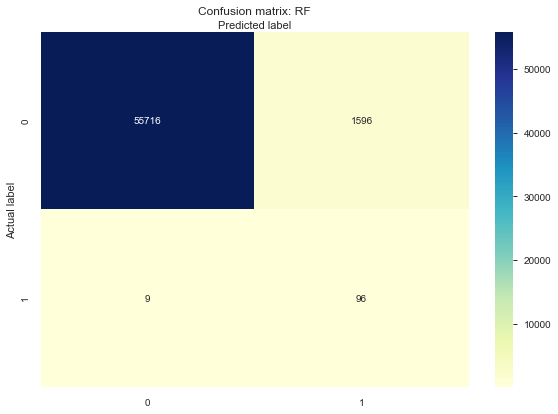

  No Skill : ROC AUC=0.500
        RF : ROC AUC=0.984


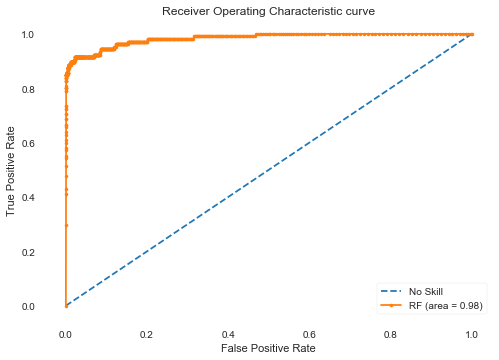

In [58]:
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train, sample_weight=np.where(y_train == 1,1.0,1.0).flatten())
rf_Pred=rf.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, rf_Pred))
tn, fp, fn, tp = display_metrics(rf, X_train, X_test, y_train, y_test, rf_Pred, 'RF')
visualize(y_test, rf_Pred, 'RF')
rf_auc = auc_roc_metrics(rf, X_test, y_test, 'RF')
metrics_results['rf'] = rf_auc

Show the results of this model

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     57312
           1       0.06      0.91      0.11       105

    accuracy                           0.97     57417
   macro avg       0.53      0.94      0.55     57417
weighted avg       1.00      0.97      0.98     57417

0.9735618370865772
Accuracy score (training): 0.952
Accuracy score (validation): 0.974
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 2.6281414911959873
tn  fp  fn  tp
55803 1509 9 96
[[55803  1509]
 [    9    96]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     57312
           1       0.06      0.91      0.11       105

    accuracy                           0.97     57417
   macro avg       0.53      0.94      0.55     57417
weighted avg       1.00      0.97      0.98     57417

Specificity = 0.9736704355108877
Sensitivity = 0.9142857142857143
SS Avg = 0.9439

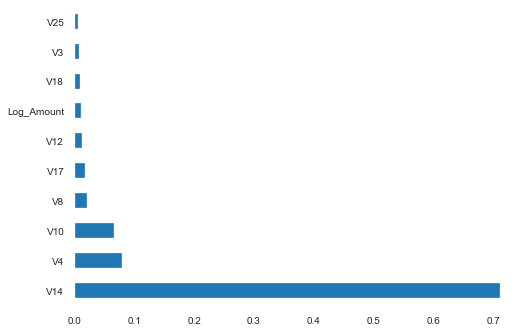

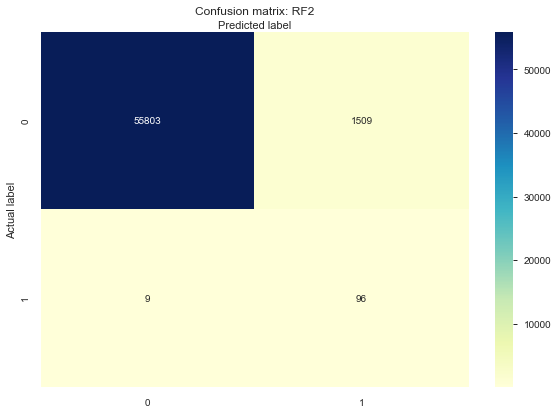

  No Skill : ROC AUC=0.500
       RF2 : ROC AUC=0.979


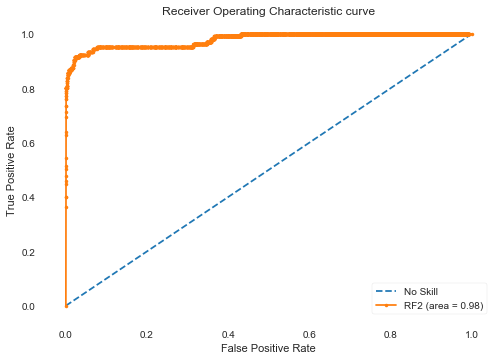

In [59]:
rf2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf2.fit(X_train, y_train, sample_weight=np.where(y_train == 1,1.0,1.0).flatten())
rf2_Pred=rf2.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, rf2_Pred))
tn, fp, fn, tp = display_metrics(rf2, X_train, X_test, y_train, y_test, rf2_Pred, 'RF2')
visualize(y_test, rf2_Pred, 'RF2')
rf2_auc = auc_roc_metrics(rf2, X_test, y_test, 'RF2')
metrics_results['rf2'] = rf2_auc

Try an unsupervised method using anamoly detection

In [60]:
rng = np.random.RandomState(42)
iso = IsolationForest(max_samples=100, random_state=rng, contamination=0.999, n_estimators=100, max_features=1.0)
iso.fit(X_train)
iso_Pred = iso.predict(X_test)
iso_Pred[iso_Pred == -1] = 0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57312
           1       0.00      0.00      0.00       105

    accuracy                           0.99     57417
   macro avg       0.50      0.50      0.50     57417
weighted avg       1.00      0.99      1.00     57417



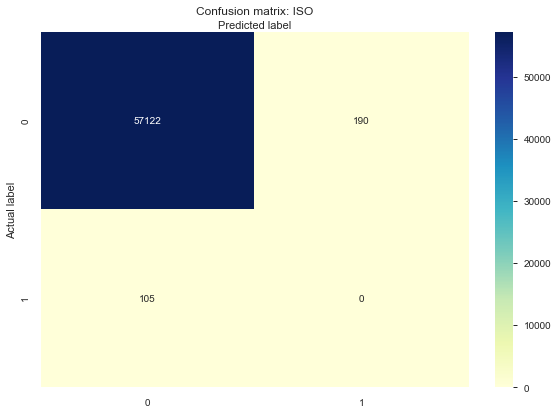

In [61]:
#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, iso_Pred))
#tn, fp, fn, tp = display_metrics(iso, X_train, X_test, y_train, y_test, iso_Pred, 'ISO')
visualize(y_test, iso_Pred, 'ISO')
#iso_auc = auc_roc_metrics(iso, X_test, y_test, 'ISO')
#metrics_results['iso'] = iso_auc

There is some variability in the results from run to run, due to random sampling and imbalanced data. This time, LogisticRegression has better prediction capability, the RandomForestClassifier test has a lot more mistakes in the False Positive category, and even a few more mistakes in the False Negative category.

Now lets try a normal GradientBoosting Algorithm

In [62]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [63]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=5, 
                                    max_depth=3, random_state=None, subsample = 0.5, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly
gb_clf.fit( X_train, y_train, sample_weight=np.where(y_train == 1,1.0,1.0) ) #  fn = 12 and fp = 1057
# no weights gives worse false positive counts
#gb_clf.fit( X_train, y_train) # fn = 8 and fp = 2639

#use model to predict validation dataset
predictions = gb_clf.predict(X_test)


Display the results

0.9788564362471045
Accuracy score (training): 0.944
Accuracy score (validation): 0.979
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 2.0969399306825505
tn  fp  fn  tp
56108 1204 10 95
[[56108  1204]
 [   10    95]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     57312
           1       0.07      0.90      0.14       105

    accuracy                           0.98     57417
   macro avg       0.54      0.94      0.56     57417
weighted avg       1.00      0.98      0.99     57417

Specificity = 0.9789921831379118
Sensitivity = 0.9047619047619048
SS Avg = 0.9418770439499082
GB:TEST | AUC Score: 0.977


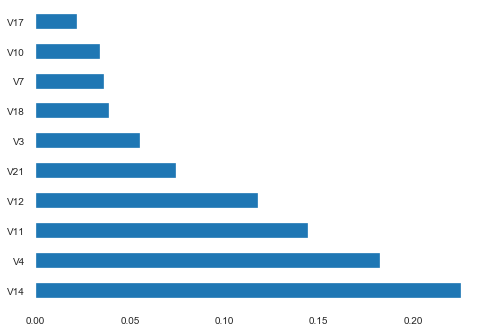

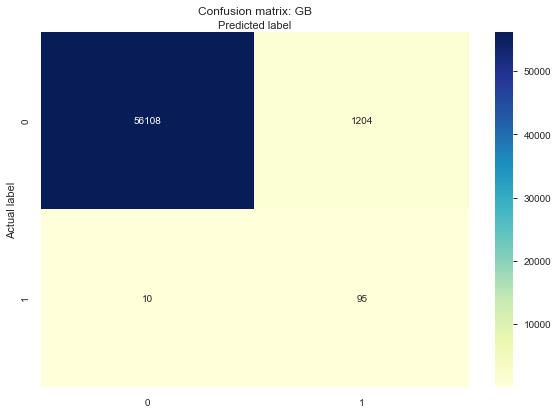

  No Skill : ROC AUC=0.500
        GB : ROC AUC=0.977


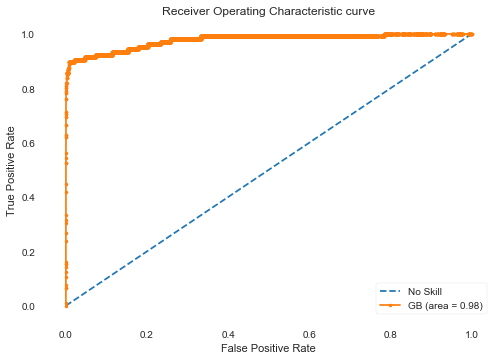

In [64]:
tn, fp, fn, tp = display_metrics(gb_clf, X_train, X_test, y_train, y_test, predictions, 'GB')
visualize(y_test, predictions, 'GB')
gb_auc = auc_roc_metrics(gb_clf, X_test, y_test, 'GB')
metrics_results['gb'] = gb_auc

After tweaking the parameters, i can get a decent result from GradientBoostingClassifier. Changing the weights has a very large influence on the number of errors (FN and FP). Since this data is mostly 0 values, decreasing the weight of a true value vs a false value will decrease the FN, doing the opposite will decrease the FP. For one example run:  the sample_weight=np.where(y_train == 1,0.37,1.0) gives 13 FN and 795 FP. sample_weight=np.where(y_train == 1,0.1,1.0) gives 17 FN and 217 FP

My next idea is to run 2 consecutive models consecutively. 1st model should have low false negatives to catch (almost) all the actual positives, even if the number of false positives is high. Then only take these records with a predicted 1 value (should only be a few thousand), as the input for the next model. 2nd test should have low false positives to weed out the actual negatives. Will use the Validate dataset on the 2 models created from the Train and Test datasets

Here are some details on the new model:

Current:  
Full Dataset -> Train -> Build M1(Train) -> Run M1(Test) -> Filter(Predicted 1's from Test) -> Build M2 -> run M2(Filtered Test)
                Test
                
To Do:               
Full Dataset -> Train -> Build M1(Train) -> Run M1(Test) -> Filter(Predicted 1's from Test) -> Build M2 -> run M1 and M2(Validate)
                Test
                Validate

Can also try the inverse, but think that option will have less chance of success.

1st step

build the 1st model to be used later on the validate dataset - optimize on high NPV (Negative Predictive Value) metric

Optimize model using GridSearchCV

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

In [66]:
#creating Scoring parameter:

# need this because npv is not available for scoring, but precision is just npv with 0 and 1 swapped
inv_y_train = 1 - y_train

scoring = {
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0)
    
}

# A sample parameter

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.5],#, 0.01],
    "min_samples_split": [0.1],
    "min_samples_leaf": [0.05],
    "max_depth":[4],
    "max_features":["log2"],
    "criterion": ["mse"],
    "subsample":[0.5],#, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[20],
    "tol": [0.001],
    "ccp_alpha": [0.001],
    "random_state": [0]
    }
#passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=10, n_jobs=-1)

#clf.fit(X_train, y_train)
clf.fit(X_train, inv_y_train, sample_weight=np.where(inv_y_train == 0,3.6,1.4) ) # was 5.0
#converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(clf.cv_results_)
df.to_csv('gb1.csv',index=False)
#here Possible inputs for cross validation is cv=2, there two split split0 and split1
df[['split0_test_precision','split1_test_precision','split0_test_accuracy','split1_test_accuracy','split0_test_sensitivity','split1_test_sensitivity','split0_test_specificity','split1_test_specificity']]

,split0_test_precision,split1_test_precision,split0_test_accuracy,split1_test_accuracy,split0_test_sensitivity,split1_test_sensitivity,split0_test_specificity,split1_test_specificity
0,0.90625,0.909091,0.904762,0.920635,0.90625,0.9375,0.903226,0.903226


In [67]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_learning_rate,param_loss,param_max_depth,param_max_features,...,split3_test_specificity,split4_test_specificity,split5_test_specificity,split6_test_specificity,split7_test_specificity,split8_test_specificity,split9_test_specificity,mean_test_specificity,std_test_specificity,rank_test_specificity
0,0.057287,0.012349,0.008979,0.002922,0.001,mse,0.5,deviance,4,log2,...,0.903226,1.0,0.84375,0.875,0.9375,0.9375,0.90625,0.917742,0.042559,1


In [68]:
# 1st step: optimize to lowest False Negative (Type 2 error) counts = high npv  tn/(tn+fn)
# 2nd step: optimize to lowest False Positive (Type 1 error) counts = high specificity  tn/(tn+fp)

#gb_clf1 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=5, 
#                                    max_depth=3, random_state=None, subsample = 1.0, criterion='mse', 
#                                    min_samples_split = 10, min_samples_leaf = 10)

gb_clf1 = GradientBoostingClassifier(loss='deviance', n_estimators=20, learning_rate=0.5, max_features="log2", 
                                    max_depth=4, random_state=0, subsample = 0.5, criterion='mse', 
                                    min_samples_split = 0.1, min_samples_leaf = 0.05, tol=0.001, ccp_alpha=0.001)

#since a false negative is much more likely than a false positive, we should weight them accordingly. 
#IE Finding a true one is more important, also more rare
gb_clf1.fit( X_train, y_train, sample_weight=np.where(y_train == 1,3.6,1.4) ) # was 5.0
predictions = gb_clf1.predict(X_test) 

0.9258581953080098
Accuracy score (training): 0.959
Accuracy score (validation): 0.926
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 7.40024731351342
tn  fp  fn  tp
53063 4249 8 97
[[53063  4249]
 [    8    97]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     57312
           1       0.02      0.92      0.04       105

    accuracy                           0.93     57417
   macro avg       0.51      0.92      0.50     57417
weighted avg       1.00      0.93      0.96     57417

Specificity = 0.9258619486320492
Sensitivity = 0.9238095238095239
SS Avg = 0.9248357362207865
GB1 Train **:TEST | AUC Score: 0.974


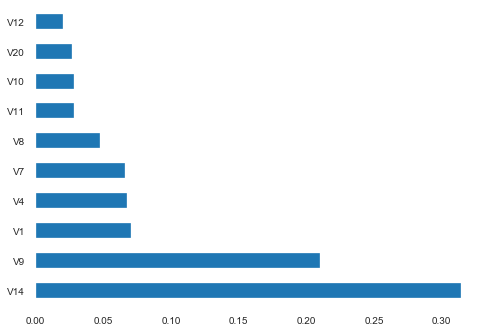

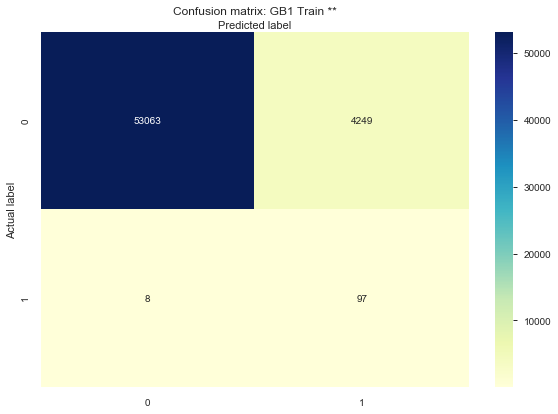

  No Skill : ROC AUC=0.500
GB1 Train ** : ROC AUC=0.974


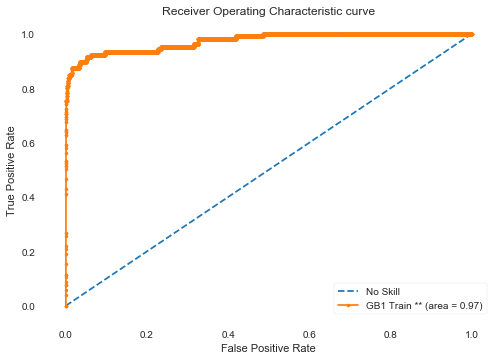

In [69]:
algo = 'GB1 Train **'
tn1, fp1, fn1, tp1 = display_metrics(gb_clf1, X_train, X_test, y_train, y_test, predictions, algo)
visualize(y_test, predictions, algo)
gb1_auc = auc_roc_metrics(gb_clf1, X_test, y_test, algo)
metrics_results['gb1_train'] = gb1_auc

2nd step takes all the Predicted Positives (the misclassified FP from upper right (~ 14000) plus the TP (since we won't use the actual value until the validation step)) and reprocesses these using a different model. The other 2 squares (Predicted 0's) are not included in the 2nd model, since we already have a low False negative result, so the initial predicted 0s don't change. Will need to add those back into the final results at the end.

Add 1st model prediction column to X_test for filtering

In [70]:
X_test['Prediction'] = predictions
# select rows with prediction of 1
yes_ind = X_test[X_test['Prediction'] == 1].index
# Create 2nd train dataset from 1st dataset where the prediction was 1
X2_test = X_test.loc[yes_ind]
y2_test = y_test.loc[yes_ind]
y_test

# clean up the X_test dataset for future modeling, means remove the Prediction column
X_test = X_test.drop(['Prediction'], axis=1)
X2_test = X2_test.drop(['Prediction'], axis=1)

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Look at the prediction values from the first model (preda_1) for the rows with a predicted label of 0

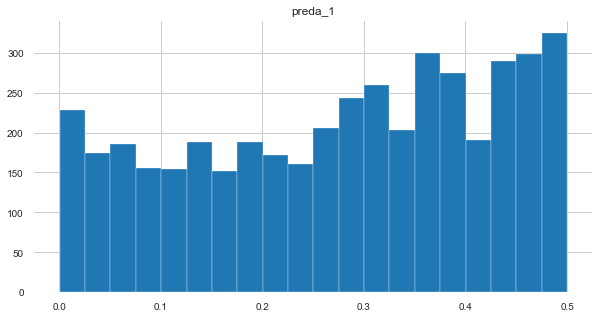

In [71]:
proba = gb_clf1.predict_proba(X2_test) 
pred = gb_clf1.predict(X2_test) 
df = pd.DataFrame(data=proba[:,0], columns=["preda_1"])
df.hist(bins=20, figsize=(10,5))
plt.show()

Then we look at the ROC curve

  No Skill : ROC AUC=0.500
PredictedPositives : ROC AUC=0.953


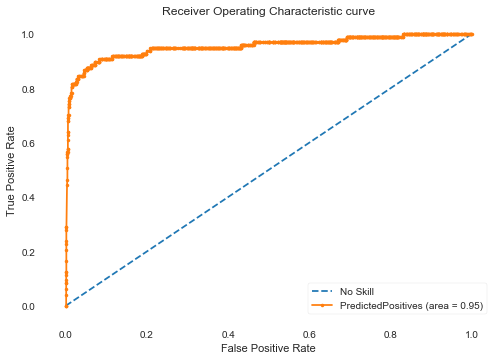

0.953

In [72]:
algo = 'PredictedPositives'
test_labels_temp = y2_test
ns_probs = [0 for _ in range(len(test_labels_temp))]
auc_roc_metrics_plots(proba[:,1], ns_probs, test_labels_temp, algo)

Next we build the 2nd model to be used model later on the validate dataset and look at the output - optimize on Specificity metric  
2nd step: optimize to lowest False Positive (Type 1 error) counts = high specificity  tn/(tn+fp)

In [73]:
#creating Scoring parameter:

scoring = {
    'specificity': make_scorer(recall_score,pos_label=0),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score)
}

# A sample parameter

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.05],#, 0.01],
    "min_samples_split": [0.1],
    "min_samples_leaf": [0.1],
    "max_depth":[4],#,5,8],
    "max_features":["log2"],
    "criterion": ["mse"],
    "subsample":[0.5],#, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[20],
    "tol": [0.001],
    "ccp_alpha": [0.05] 
}

#passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=10, n_jobs=-1)

clf.fit(X_train, y_train)
#converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(clf.cv_results_)
df.to_csv('gb1.csv',index=False)
#here Possible inputs for cross validation is cv=2, there two split split0 and split1
df[['split0_test_specificity','split1_test_specificity','split0_test_accuracy','split1_test_accuracy','split0_test_precision','split1_test_precision','split0_test_sensitivity','split1_test_sensitivity']]


,split0_test_specificity,split1_test_specificity,split0_test_accuracy,split1_test_accuracy,split0_test_precision,split1_test_precision,split0_test_sensitivity,split1_test_sensitivity
0,0.96875,1.0,0.873016,0.873016,0.96,1.0,0.774194,0.741935


0.0223193741371376
Accuracy score (training): 0.500
Accuracy score (validation): 0.022
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 97.76806258628625
tn  fp  fn  tp
0 4249 0 97
[[   0 4249]
 [   0   97]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4249
           1       0.02      1.00      0.04        97

    accuracy                           0.02      4346
   macro avg       0.01      0.50      0.02      4346
weighted avg       0.00      0.02      0.00      4346

Specificity = 0.0
Sensitivity = 1.0
SS Avg = 0.5
GB2 Train **:TEST | AUC Score: 0.959


C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


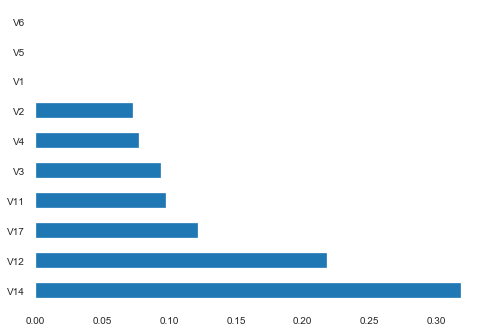

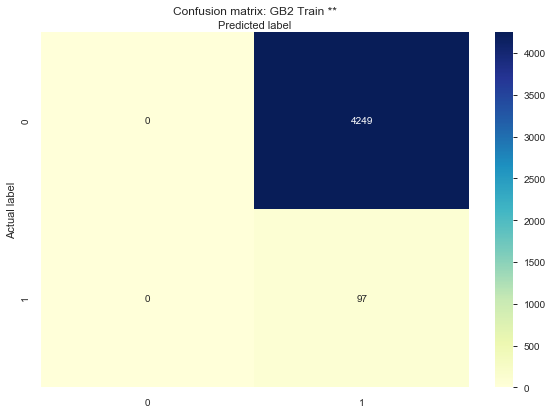

  No Skill : ROC AUC=0.500
GB2 Train ** : ROC AUC=0.959


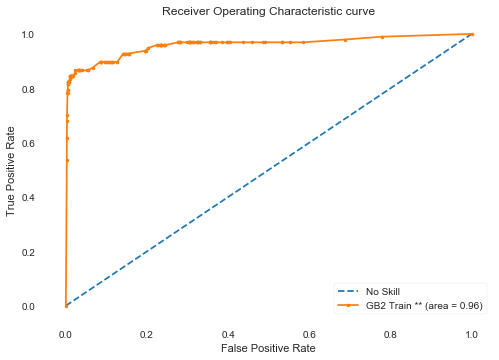

2 Step Final Confusion Matrix:
53063 4249
8 97


Text(0.5, 352.48, 'Predicted label')

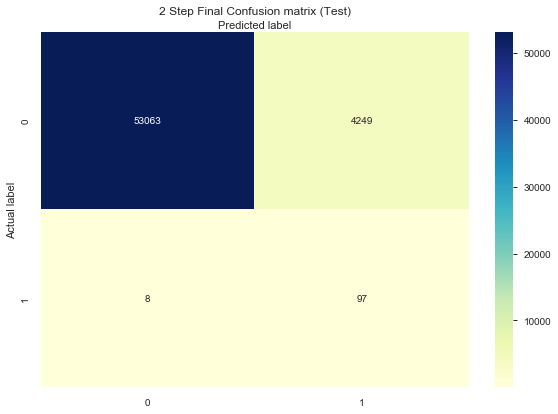

In [74]:
#setup model parameters, change some of the defaults based on benchmarking
#gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=10, 
#                                    max_depth=3, random_state=None, subsample = 1.0, criterion='mse', 
#                                    min_samples_split = 10, min_samples_leaf = 10)

gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.05, max_features="log2", 
                                    max_depth=4, random_state=None, subsample = 0.5, criterion='mse', 
                                    min_samples_split = 0.1, min_samples_leaf = 0.1, tol = 0.001, ccp_alpha = 0.05)

#default fit model
#gb_clf2.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly. 
#IE Finding a true one is more important
# note that the weights in the 2nd model are the inverse of the weights in the 1st model
gb_clf2.fit( X_train, y_train, sample_weight=np.where(y_train == 1,3.6,1.4) ) # was 0.1 but should be > 1 to work correctly

#use model to predict validation dataset
predictions = gb_clf2.predict(X2_test) 

algo = 'GB2 Train **'
tn, fp, fn, tp = display_metrics(gb_clf2, X_train, X2_test, y_train, y2_test, predictions, algo)

visualize(y2_test, predictions, algo)

gb2_auc = auc_roc_metrics(gb_clf2, X2_test, y2_test, algo)
metrics_results['gb2_train'] = gb2_auc

print("2 Step Final Confusion Matrix:")
print(tn+tn1, fp) 
print(fn+fn1, tp) 

fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)

#create heatmap with combined data from both models
sns.heatmap(pd.DataFrame([[tn+tn1,fp],[fn+fn1,tp]]), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('2 Step Final Confusion matrix (Test)', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

Now that we have built the 2 models from the test dataset, run the untouched validate dataset through both of them to get an unbiased result to compare against

In [75]:
# run the validate dataset through the first model
algo = '2-Step'
predictions1 = gb_clf1.predict(X_val)
predictions_proba1 = gb_clf1.predict_proba(X_val)
X1_val_final = X_val.copy()
X1_val_final=X1_val_final.join(y_val)
X1_val_final['Proba_1'] = predictions_proba1[:,1]
#X1_val_final
#X_val = X_val.sort_index(axis = 0) 

0.9254555127011571
Accuracy score (training): 0.926
Accuracy score (validation): 0.925
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 7.447798909429445
tn  fp  fn  tp
41682 3360 3 69
[[41682  3360]
 [    3    69]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     45042
           1       0.02      0.96      0.04        72

    accuracy                           0.93     45114
   macro avg       0.51      0.94      0.50     45114
weighted avg       1.00      0.93      0.96     45114

Specificity = 0.9254029572399094
Sensitivity = 0.9583333333333334
SS Avg = 0.9418681452866213
GB1 Validate **:TEST | AUC Score: 0.989


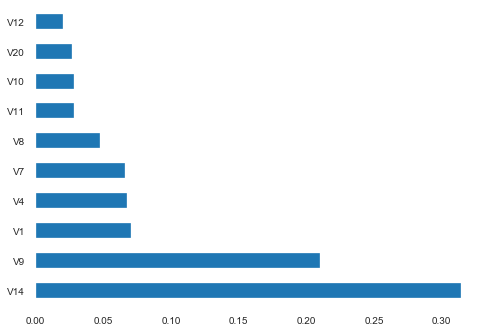

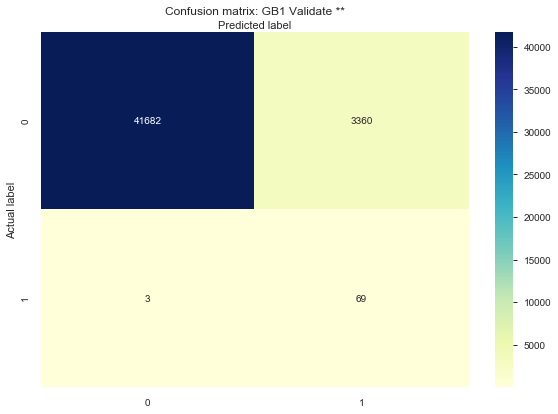

  No Skill : ROC AUC=0.500
GB1 Validate ** : ROC AUC=0.989


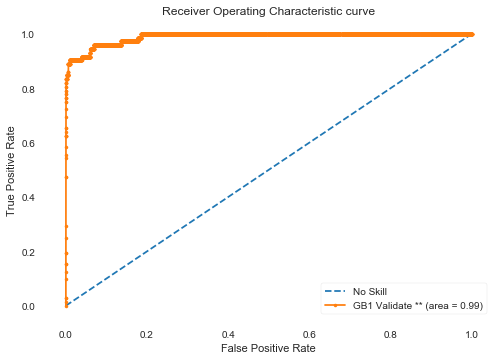

In [76]:
# adding this
# use both models to predict final validation dataset
algo = 'GB1 Validate **'
tn1, fp1, fn1, tp1 = display_metrics(gb_clf1, X_test, X_val, y_test, y_val, predictions1, algo) 
visualize(y_val, predictions1, algo)
gb1_auc = auc_roc_metrics(gb_clf1, X_val, y_val, algo)
metrics_results['gb1_validate'] = gb1_auc


In [77]:

X_val['Prediction'] = predictions1

yes_ind = X_val[X_val['Prediction'] == 1].index

X2_val = X_val.loc[yes_ind]
y2_val = y_val.loc[yes_ind]
X2_val = X2_val.drop(['Prediction'], axis=1)
# run the validate dataset through the second model
predictions2 = gb_clf2.predict(X2_val)

X2_val_final = X2_val.copy()
X2_val_final.join(y2_val)
predictions_proba2 = gb_clf2.predict_proba(X2_val)
# validate the join!!
X2_val_final['Proba_2'] = predictions_proba2[:,1]
X2_val_final

cols_to_use = X2_val_final.columns.difference(X1_val_final.columns)
X_val_final = X1_val_final.join(X2_val_final[cols_to_use], how='left', lsuffix='_1', rsuffix='_2')
# rowwise action (axis=1)
X_val_final.loc[X_val_final['Proba_2'].isnull(),'Proba_2'] = X_val_final['Proba_1']
#X_val_final['Proba_2'].fillna(df['Proba_1'])
#X_val_final.query("Proba_1 != Proba_2")

#remove this column for use later
X_val = X_val.drop(['Prediction'], axis=1)

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.020122484689413824
Accuracy score (training): 0.500
Accuracy score (validation): 0.020
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 97.98775153105862
tn  fp  fn  tp
0 3360 0 69
[[   0 3360]
 [   0   69]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3360
           1       0.02      1.00      0.04        69

    accuracy                           0.02      3429
   macro avg       0.01      0.50      0.02      3429
weighted avg       0.00      0.02      0.00      3429

Specificity = 0.0
Sensitivity = 1.0
SS Avg = 0.5
GB2 Validate **:TEST | AUC Score: 0.983


C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


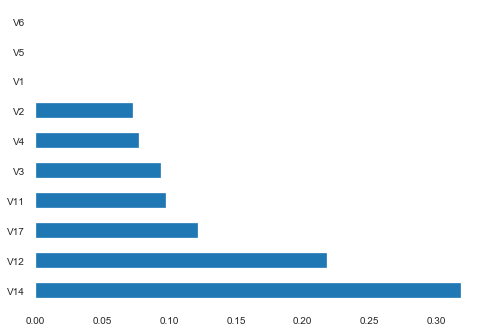

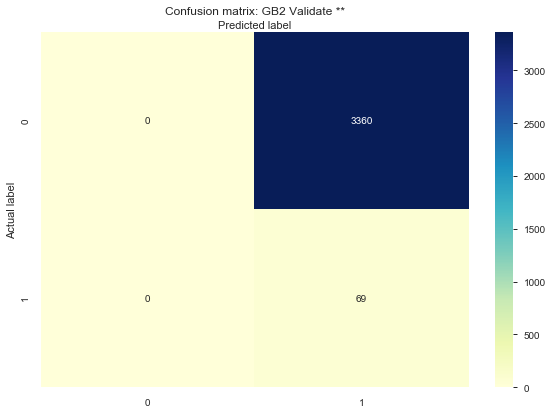

  No Skill : ROC AUC=0.500
GB2 Validate ** : ROC AUC=0.983


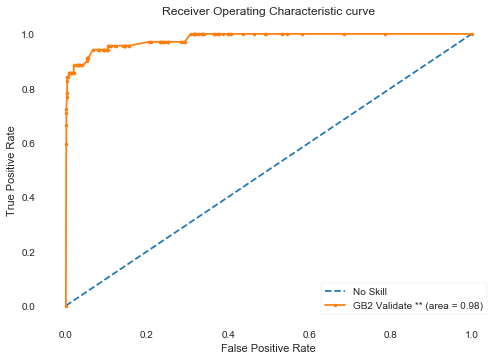

2 Step Final Confusion Matrix:
41682 3360
3 69
Specificity = 0.9254029572399094
Sensitivity = 0.9583333333333334
SS Avg =  0.9418681452866213
2 Step Algorithm:TEST | AUC Score: 0.942


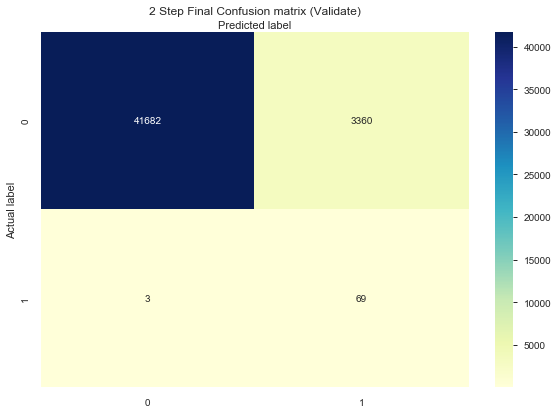

In [78]:
algo = 'GB2 Validate **'
tn, fp, fn, tp = display_metrics(gb_clf2, X_train, X2_val, y_train, y2_val, predictions2, algo) 
visualize(y2_val, predictions2, algo)
gb2_auc = auc_roc_metrics(gb_clf2, X2_val, y2_val, algo)
metrics_results['gb2_validate'] = gb2_auc

print("2 Step Final Confusion Matrix:")
print(tn+tn1, fp) 
print(fn+fn1, tp) 

fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)

#create heatmap with combined data from both models
sns.heatmap(pd.DataFrame([[tn+tn1,fp],[fn+fn1,tp]]), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('2 Step Final Confusion matrix (Validate)', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

algo = '2-Step'
Specificity = (tn+tn1)/(tn+tn1+fp)
Sensitivity = tp/(tp+fn+fn1)

print("Specificity =", Specificity)
print("Sensitivity =", Sensitivity)
print('SS Avg = ', (Specificity + Sensitivity)/2)

print('2 Step Algorithm' + ':TEST | AUC Score: ' + str( round( (Specificity+Sensitivity)/2,3 )))

cm_results.append([algo, (tn+tn1), fp, (fn+fn1), tp])
# HERE
#two_step_auc = auc_roc_metrics(gb_clf, X_test, y_test, '2-Step')

  No Skill : ROC AUC=0.500
    2-Step : ROC AUC=0.992


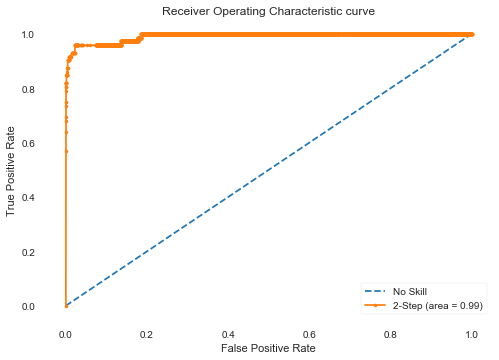

In [79]:
# try to combine the 2 models into one AUC score, however not sure that the proba values from 2 different models can be combined 

test_labels_temp = X_val_final['Class']
ns_probs = [0 for _ in range(len(test_labels_temp))]
model_probs = X_val_final['Proba_2']
model_pred=[1 if i > 0.50 else 0 for i in model_probs]

two_step_auc = auc_roc_metrics_plots(model_probs, ns_probs, test_labels_temp, algo)

metrics_results['2-step'] = two_step_auc

cr_results.append([algo, classification_report(test_labels_temp, model_pred)])

In [80]:
y=np.reshape(test_labels_temp.to_numpy(), -1)
fpr, tpr, thresholds = metrics.roc_curve(y, model_probs, pos_label=1)
roc.append([algo, fpr, tpr, thresholds])

2nd round:

0: 0.4 1: 1.0
[[54456  2856]
 [    8    97]]
[[   0 2856]
 [   0   97]]
combined test: 54456 2856 8 97
[[42802  2240]
 [    4    68]]
[[   0 2240]
 [   0   68]]
combined val: 42802 2240 4 68
Specificity = 0.9502686381599396
Sensitivity = 0.9444444444444444
SS Avg =  0.947356541302192
  No Skill : ROC AUC=0.500
2-Step_2nd : ROC AUC=0.993


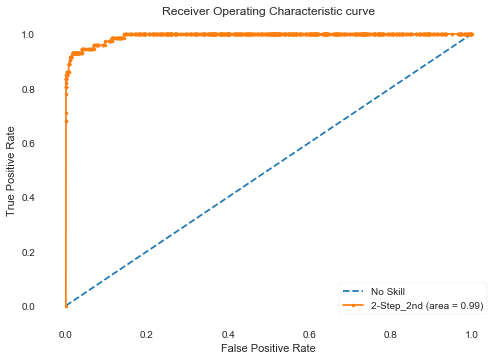

In [81]:
# 1st step: optimize to lowest False Negative (Type 2 error) counts = high npv  tn/(tn+fn)
# 2nd step: optimize to lowest False Positive (Type 1 error) counts = high specificity  tn/(tn+fp)

# can add: validation_fractionfloat=0.1, default=0.1
#          n_iter_no_changeint=20, default=None

neg, pos = np.bincount(y_train)
total = neg + pos
initial_bias = np.log([pos/neg])

weight_for_0 = (1 / neg)*(total)/5.0 # was 5
weight_for_1 = (1 / pos)*(total)/2.0 # was 2

a='''
gb_clf1 = GradientBoostingClassifier(loss='deviance', n_estimators=20, learning_rate=0.5, max_features="log2", 
                                    max_depth=4, random_state=0, subsample = 0.5, criterion='mse', 
                                    min_samples_split = 0.1, min_samples_leaf = 0.05, tol=0.001, ccp_alpha=0.001)

gb_clf1.fit( X_train, y_train, sample_weight=np.where(y_train == 1,3.6,1.4) ) # was 5.0
'''


class_weight = {0: weight_for_0, 1: weight_for_1}
print('0:', weight_for_0, '1:', weight_for_1)

# can try Bayesian, could be better and boosting_type='Plain'
gb_clf1 = CatBoostClassifier(iterations=200, learning_rate=0.01, class_weights=class_weight,
    eval_metric='Logloss', random_seed=0, custom_loss=['AUC'], loss_function='Logloss',
    bootstrap_type='MVS', subsample=0.76, mvs_reg=0.0, random_strength=1.0, use_best_model=True,           
    max_depth=6, boosting_type='Ordered',  boost_from_average=False
)

#since a false negative is much more likely than a false positive, we should weight them accordingly. 
#IE Finding a true one is more important, also more rare
gb_clf1.fit(X_train, y_train, 
        #cat_features=cat_features, 
        eval_set=(val_features, val_labels), 
        verbose=False,
)


predictions = gb_clf1.predict(X_test) 

print(metrics.confusion_matrix(y_test, predictions))
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, predictions).ravel()

# Add 1st model prediction column to X_test for filtering

X_test['Prediction'] = predictions
# select rows with prediction of 1
yes_ind = X_test[X_test['Prediction'] == 1].index
# Create 2nd train dataset from 1st dataset where the prediction was 1
X2_test = X_test.loc[yes_ind]
y2_test = y_test.loc[yes_ind]

# clean up the X_test dataset for future modeling, means remove the Prediction column
X_test = X_test.drop(['Prediction'], axis=1)
X2_test = X2_test.drop(['Prediction'], axis=1)

# Next we build the 2nd model to be used model later on the validate dataset and look at the output - optimize on Specificity metric  
# 2nd step: optimize to lowest False Positive (Type 1 error) counts = high specificity  tn/(tn+fp)

gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.05, max_features="log2", 
                                    max_depth=4, random_state=None, subsample = 0.5, criterion='mse', 
                                    min_samples_split = 0.1, min_samples_leaf = 0.1, tol = 0.001, ccp_alpha = 0.05)

# since a false negative is much more likely than a false positive, we should weight them accordingly. 
# IE Finding a true one is more important
# note that the weights in the 2nd model are the inverse of the weights in the 1st model
gb_clf2.fit( X_train, y_train, sample_weight=np.where(y_train == 1,3.6,1.4) ) # was 0.1 but should be > 1 to work correctly

#use model to predict validation dataset
predictions = gb_clf2.predict(X2_test) 

print(metrics.confusion_matrix(y2_test, predictions))
tn, fp, fn, tp = confusion_matrix(y2_test, predictions).ravel()
print("combined test:", tn+tn1, fp, fn+fn1, tp)

# run the validate dataset through the first model
algo = '2-Step'
predictions1 = gb_clf1.predict(X_val)
tn1, fp1, fn1, tp1 = confusion_matrix(y_val, predictions1).ravel()
print(metrics.confusion_matrix(y_val, predictions1))

predictions_proba1 = gb_clf1.predict_proba(X_val)
X1_val_final = X_val.copy()
X1_val_final=X1_val_final.join(y_val)
X1_val_final['Proba_1'] = predictions_proba1[:,1]

# adding this
# use both models to predict final validation dataset

X_val['Prediction'] = predictions1
# add column for filtering
yes_ind = X_val[X_val['Prediction'] == 1].index

# filter dataset to include only the predicted value of 1
X2_val = X_val.loc[yes_ind]
y2_val = y_val.loc[yes_ind]
X2_val = X2_val.drop(['Prediction'], axis=1)
# after filtering, run the validate dataset through the second model
predictions2 = gb_clf2.predict(X2_val)

X2_val_final = X2_val.copy()
X2_val_final.join(y2_val)
predictions_proba2 = gb_clf2.predict_proba(X2_val)
# validate the join!!
X2_val_final['Proba_2'] = predictions_proba2[:,1]
X2_val_final

cols_to_use = X2_val_final.columns.difference(X1_val_final.columns)
X_val_final = X1_val_final.join(X2_val_final[cols_to_use], how='left', lsuffix='_1', rsuffix='_2')
X_val_final.loc[X_val_final['Proba_2'].isnull(),'Proba_2'] = X_val_final['Proba_1']

#remove this column for use later
X_val = X_val.drop(['Prediction'], axis=1)

print(metrics.confusion_matrix(y2_val, predictions2))
tn, fp, fn, tp = confusion_matrix(y2_val, predictions2).ravel()
print("combined val:", tn+tn1, fp, fn+fn1, tp)

algo = '2-Step_2nd'
Specificity = (tn+tn1)/(tn+tn1+fp)
Sensitivity = tp/(tp+fn+fn1)

print("Specificity =", Specificity)
print("Sensitivity =", Sensitivity)
print('SS Avg = ', (Specificity + Sensitivity)/2)

cm_results.append([algo, (tn+tn1), fp, (fn+fn1), tp])

# try to combine the 2 models into one AUC score, however not sure that the proba values from 2 different models can be combined 

test_labels_temp = X_val_final['Class']
ns_probs = [0 for _ in range(len(test_labels_temp))]
model_probs = X_val_final['Proba_2']
model_pred=[1 if i > 0.50 else 0 for i in model_probs]

two_step_auc = auc_roc_metrics_plots(model_probs, ns_probs, test_labels_temp, algo)
metrics_results['2-step'] = two_step_auc
cr_results.append([algo, classification_report(test_labels_temp, model_pred)])

y=np.reshape(test_labels_temp.to_numpy(), -1)
fpr, tpr, thresholds = metrics.roc_curve(y, model_probs, pos_label=1)
roc.append([algo, fpr, tpr, thresholds])

The 2 step process has the highest sensitivity (and specificity) between the models. The 2 step process also improves the overall model prediction of positives by a large amount (FP/TP ratio from above 10x to below 2x). I don't think we could get this high of precision and recall together with a single model. The best I could do with a single model was 10x FP/TP ratio.

Next will try a few Neural Networks

In [82]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
#from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import backend as K
from keras.layers import Conv1D
from keras.layers import BatchNormalization
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

Using TensorFlow backend.


Adding swish activation function code for possible use later, can compare to relu, etc

In [81]:
# create new activation function
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [82]:
# add this function to the list of Activation functions
get_custom_objects().update({'swish': Activation(swish)})

Create the models to be used layer, using Sequential()

In [83]:
def create_dnn(input_dim):
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=input_dim, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dropout(0.25),
        Dense(20, kernel_initializer='uniform', activation='relu'),
        Dense(24, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [84]:
def create_simple_dnn(input_dim):
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=input_dim, activation='relu'),
        Dropout(0.25),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [85]:
def create_dnn_complex(input_dim):
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=input_dim, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=28, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=28, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=20, kernel_initializer='uniform', activation='relu'),
        Dense(units=24, kernel_initializer='uniform', activation='relu'),
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [86]:
# source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
def create_online_dnn(input_dim, output_bias=0):
    output_bias = keras.initializers.Constant(output_bias)
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=input_dim, activation='relu'),
        Dropout(0.25),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid', bias_initializer=output_bias)
        #Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])
    return clf1

In [87]:
def create_cnn(input_shape):
    model = Sequential()
    #model.add(Conv1D(32, 2, activation = 'relu', input_shape = input_shape))
    #model.add(Conv1D(filters=32, kernel_size=2, input_shape = (30) ))
    #model.add(Conv1D(filters=32, kernel_size=10, strides=1, activation='swish', padding='valid', input_shape=input_shape ))
    model.add(Conv1D(filters=32, kernel_size=10, strides=1, activation='relu', padding='valid', input_shape=input_shape ))
    # TypeError: 'int' object is not iterable
    model.add(BatchNormalization())
    model.add(MaxPool1D(2))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [88]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.confusion = []
        self.precision = []
        self.npv = []
        self.recall = []
        self.specificity = []
        self.f1s = []
        self.kappa = []
        self.auc = []

    def on_epoch_end(self, epoch, logs={}):
        score = np.asarray(self.model.predict(self.validation_data[0]))
        predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
        targ = self.validation_data[1]

        self.auc.append(sklm.roc_auc_score(targ, score))
        self.confusion.append(sklm.confusion_matrix(targ, predict))
        self.precision.append(sklm.precision_score(targ, predict))
        self.npv.append(sklm.precision_score(1-targ, 1-predict))
        self.recall.append(sklm.recall_score(targ, predict))
        self.specificity.append(sklm.recall_score(1-targ, 1-predict))
        self.f1s.append(sklm.f1_score(targ, predict))
        self.kappa.append(sklm.cohen_kappa_score(targ, predict))
        print('precision: ', sklm.precision_score(targ, predict))
        print('recall: ', sklm.recall_score(targ, predict))
        print('npv: ', sklm.precision_score(1-targ, 1-predict))
        print('specificity: ', sklm.recall_score(1-targ, 1-predict))

        return

In [89]:
import keras.backend as K
def custom_loss_abs_sum(y_true, y_pred):
    loss = abs(y_true - y_pred)
    return loss
#clf.compile(optimizer='adam', loss=custom_loss_abs_sum, metrics=['accuracy']) 

In [90]:
# list of all metrics: https://www.tensorflow.org/api_docs/python/tf/keras/metrics
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.BinaryCrossentropy(name='crossentropy', from_logits=False, label_smoothing=0),
      keras.metrics.SensitivityAtSpecificity(specificity=0.0, num_thresholds=200, name='sensitivity'),  # (tp / (tp + fn)).
      keras.metrics.SpecificityAtSensitivity(sensitivity=0.0, num_thresholds=200, name='specificity'),   # (tn / (tn + fp)).
      keras.metrics.CosineSimilarity(name='cosine_similarity', axis=-1),
      keras.metrics.KLDivergence(name='kl_divergence'),
      keras.metrics.LogCoshError(name='logcosh'),
]

run the CNN model

Input shape: (29, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20, 32)            352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 64)             4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 64)             256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (Non

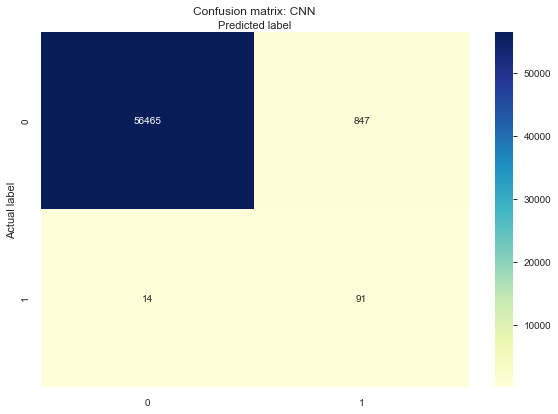

  No Skill : ROC AUC=0.500
       CNN : ROC AUC=0.972


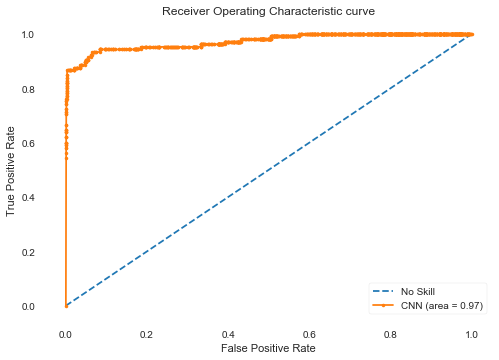

In [91]:
input_shape = (X_train.shape[1], 1)
input_dim = X_train.shape[1]
print("Input shape:", input_shape)
clf = create_cnn(input_shape)
# NameError: name 'input_shape' is not defined

# reshape data for CNN expected input
nrows, ncols = X_train.shape # (602,30)
X_train_arr = X_train.copy().to_numpy()
y_train_arr = y_train.copy()
X_train_arr = X_train_arr.reshape(nrows, ncols, 1)

nrows, ncols = X_test.shape # (602,30)
X_test_arr = X_test.copy().to_numpy()
y_test_arr = y_test.copy()
X_test_arr = X_test_arr.reshape(nrows, ncols, 1)

nrows, ncols = X_val.shape # (602,30)
X_val_arr = X_val.copy().to_numpy()
y_val_arr = y_val.copy()
X_val_arr = X_val_arr.reshape(nrows, ncols, 1)

#opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
# Let's train the model using RMSprop
#clf.compile(loss='binary_crossentropy',
#              optimizer=opt,
#              metrics=['accuracy'])
# or
#clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
clf.compile(optimizer='adam', loss=custom_loss_abs_sum, metrics=['accuracy'])  

clf.summary()

#adam = keras.optimizers.Adam(learning_rate=0.001)
# try using focal_loss to give heavier weight to examples that are difficult to classify
# seems to improve the metrics slightly
#clf.compile(optimizer=adam, loss=[focal_loss], metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,0.2,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=16, epochs=20, sample_weight=np.where(y_train == 1,1.0,1.0).flatten())
# or

clf.fit(X_train_arr, y_train_arr, epochs=20, verbose=1, 
        sample_weight=np.where(y_train_arr == 1,1.0,1.0).flatten(), 
        shuffle=True, validation_data=(X_val_arr, y_val_arr))
# check model metrics
score = clf.evaluate(X_train_arr, y_train_arr, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test_arr, y_test_arr, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test_arr, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test_arr, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (CNN)") 
print(classification_report(y_test_arr, yhat_classes))

tn, fp, fn, tp = display_metrics(clf, X_train_arr, X_test_arr, y_train_arr, y_test_arr, yhat_classes, 'CNN')
visualize(y_test_arr, yhat_classes, 'CNN')
cnn_auc = auc_roc_metrics(clf, X_test_arr, y_test_arr, 'CNN')
metrics_results['cnn'] = cnn_auc

In [92]:
X_train.shape[1]

29

Now run the basic DNN (Deep Neural Network)

for Custom Loss fit to Train dataset (balanced):  

Use Keras/Tensor math functions!  
reference: https://www.tensorflow.org/api_docs/python/tf/keras/backend/  

Predictions on test dataset:  

loss = y_true - y_pred => all predictions are 1, fn are loss=+1, fp are loss=-1  
[[    0 59708]  
[    0   102]]  

loss = y_pred - y_true => all predictions are 0, fp are loss=+1, fn are loss=-1  
[[59708     0]  
 [  102     0]]  
 
loss = abs(y_true - y_pred) => all mistakes have equal weight  

[[57693  2015]  
 [   12    90]]  

In [93]:
# https://www.tensorflow.org/api_docs/python/tf/keras/backend/

import keras.backend as K
def custom_loss_mask(y_true, y_pred):
    #loss = abs(y_true - y_pred)
    
    mask1 = K.less(y_pred, y_true) # is y_pred < y_true or y_pred - y_true < 0, FN
    mask2 = K.less(y_true, y_pred) # is y_true < y_pred or y_true - y_pred < 0, FP
    #loss = K.cast(mask1, K.floatx()) * 2 * (y_true - y_pred) # only include FN
    loss = (K.cast(mask1, K.floatx()) * 2 * (y_true - y_pred)) + (K.cast(mask2, K.floatx()) * 4 * (y_pred - y_true)) # only include FN
    return loss
#clf.compile(optimizer='adam', loss=custom_loss_mask, metrics=['accuracy']) 

In [94]:
# define variable learning rate function
from keras.callbacks import LearningRateScheduler, EarlyStopping, History, LambdaCallback
import math

def step_decay(epoch, lr):
    drop = 0.995 # was .999
    epochs_drop = 5.0 # was 175, sgd likes 200+, adam likes 100
    lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print("epoch=" + str(epoch) + " lr=" + str(lr) + " lrate=" + str(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, mode='auto', restore_best_weights = True)
callbacks_list = [lrate, early_stopping] 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 18)                306       
_________________________________________________________________
dropout_4 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                380       
_________________________________________________________________
dense_6 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 1,695
Trainable params: 1,695
Non-trainable params: 0
____________________________________________________

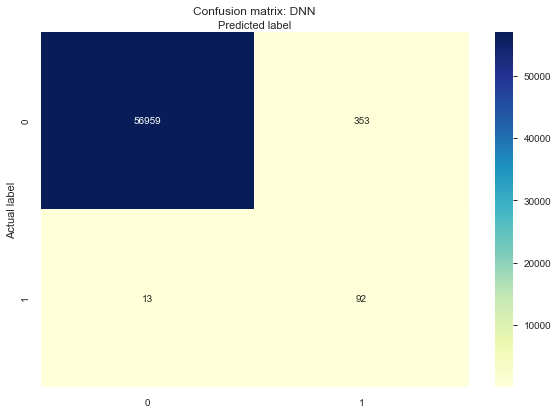

  No Skill : ROC AUC=0.500
       DNN : ROC AUC=0.928


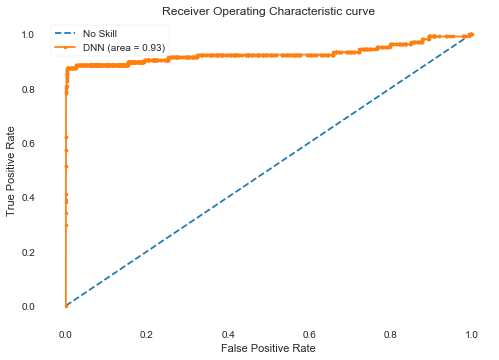

In [95]:
from keras.optimizers import Adam, SGD, RMSprop

verbose=1
clf = create_dnn(input_dim)
clf.summary()
#clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

learning_rate = 0.0001
decay = 0.0002
momentum=0.99
opt_sel = "adam"
if (opt_sel == "adam"):
    #opt = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, amsgrad=amsgrad) # added to v86
    opt = Adam(lr=learning_rate)
elif(opt_sel == "sgd"):
    opt = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay, nesterov=True)

clf.compile(optimizer=opt, loss=custom_loss_mask, metrics=['accuracy'])

#adam = keras.optimizers.Adam(learning_rate=0.001)
# try using focal_loss to give heavier weight to examples that are difficult to classify
# seems to improve the metrics slightly
#clf.compile(optimizer=adam, loss=[focal_loss], metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,0.2,1.0).flatten())
clf.fit(X_train, y_train, batch_size=16, epochs=200, verbose=verbose, 
        sample_weight=np.where(y_train == 1,1.0,1.0).flatten(), 
        callbacks=callbacks_list, validation_data=(X_val, y_val))

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN)") 
print(classification_report(y_test, yhat_classes))

tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN')
visualize(y_test, yhat_classes, 'DNN')
dnn_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN')
metrics_results['dnn'] = dnn_auc

Results from Deep NN are better than 1 step/model examples, but overall not quite as good as the 2 step/model process. I can get the sensitivity to be as good, but in that case, the specificity is much lower. As more data is added or processed through this DNN, the results should improve, maybe eventually beating the 2 step model. However, it seems that increasing the number of epochs will weight the model to higher false negatives, similar to using sample weights for the GBM model:

**sample_weight=np.where(y_train == 1,0.1,1.0)**

**giving a 1 in the training data 10 times the weight or inflence of a 0**

For now, we will keep the number of epochs at 5.
Weighting has the same effect on this DNN as it had on the GBM. Best all around result with 

sample_weight=np.where(y_train == 1,0.1,1.0).flatten()

Look at simpler and more complex examples of a DNN for comparison

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                480       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 18)                306       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 19        
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________
Train on 630 samples, validate on 45114 samples
Epoch 1/32
epoch=0 lr=0.0010000000474974513 lrate=0.0010000000474974513
630/630 [==============================] - 1s 2ms/step - loss: 0.6844 - accuracy: 0.8460 - val_loss: 0.6907 - val_accuracy: 0.8911
Epo

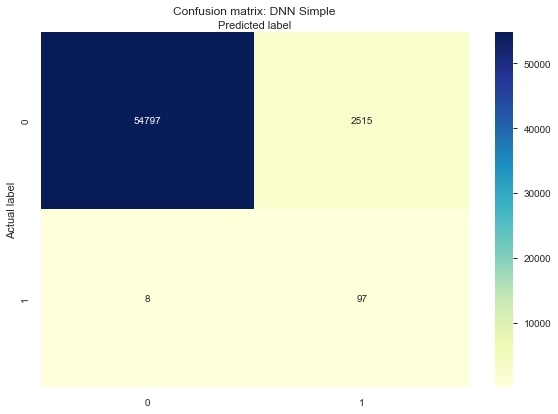

  No Skill : ROC AUC=0.500
DNN-Simple : ROC AUC=0.973


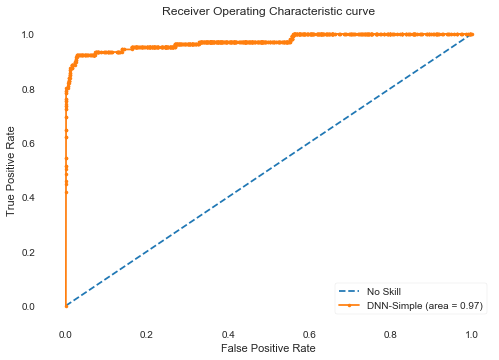

In [96]:
clf = create_simple_dnn(input_dim)
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
clf.fit(X_train, y_train, batch_size=32, epochs=32, verbose=verbose, sample_weight=np.where(y_train == 1,1.0,1.0).flatten(), 
        callbacks=callbacks_list, validation_data=(X_val, y_val))
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN Simple)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN Simple')
visualize(y_test, yhat_classes, 'DNN Simple')
dnn_simple_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN-Simple')
metrics_results['dnn_simple'] = dnn_simple_auc

In [97]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall', 'accuracy', 'crossentropy','fn','fp']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,4,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        elif metric == 'fn':
            plt.ylim([0,100])
        elif metric == 'fp':
            plt.ylim([0,5000])
        elif metric == 'accuracy':
            plt.ylim([0.8,1])
        elif metric == 'crossentropy':
            plt.ylim([0,0.2])
        elif metric == 'precision':
            plt.ylim([0,0.2])
        elif metric == 'recall':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

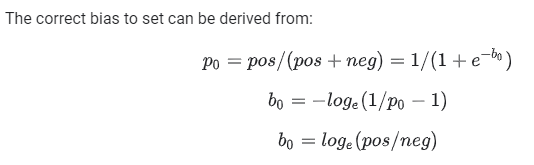

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                480       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 18)                306       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 19        
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________
Train on 630 samples, validate on 45114 samples
Epoch 1/100
epoch=0 lr=0.0010000000474974513 lrate=0.0010000000474974513
630/630 [==============================] - 3s 5ms/step - loss: 0.6838 - tp: 250.0000 - fp: 68.0000 - tn: 247.0000 - fn: 65.0000 - acc

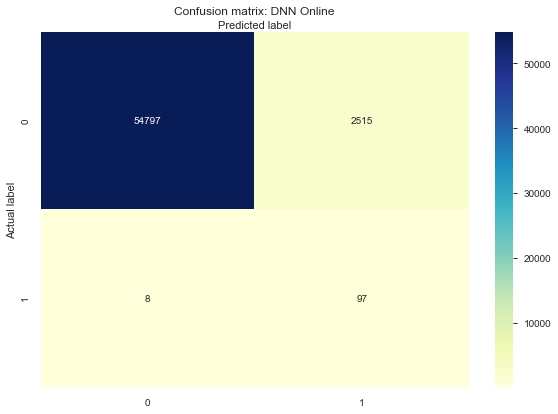

  No Skill : ROC AUC=0.500
DNN-Online : ROC AUC=0.971


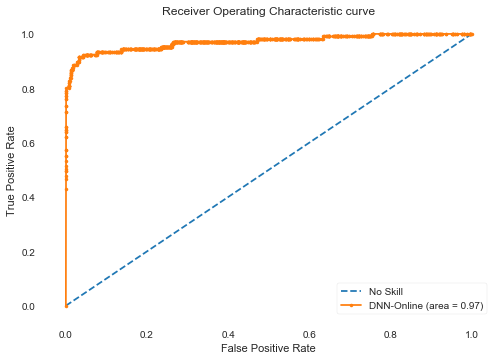

In [98]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=25, mode='auto', restore_best_weights = True)
#callbacks_list = [lrate, early_stopping] 
neg, pos = np.bincount(y_train)
initial_bias = np.log([pos/neg])
clf = create_online_dnn(input_dim=input_dim, output_bias = initial_bias)
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
# create/fit model on the training dataset
baseline_history = clf.fit(X_train, y_train, batch_size=32, epochs=100, 
        verbose=verbose, sample_weight=np.where(y_train == 1,1.0,1.0).flatten(), 
        callbacks=callbacks_list, validation_data=(X_val, y_val))
# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
print('\nThe loss is ',score[0])
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN Online)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN Online')
visualize(y_test, yhat_classes, 'DNN Online')
dnn_online_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN-Online')
metrics_results['dnn_online'] = dnn_online_auc
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#plot_metrics(baseline_history)

This DNN is successful at reducing the FP/TP ratio. This is expected as a Neural Network can decide on its own rules to include based on the input data. Below I try other more and less complex methods, but so far the results are not as good.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                480       
_________________________________________________________________
dense_15 (Dense)             (None, 18)                306       
_________________________________________________________________
dropout_7 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 30)                570       
_________________________________________________________________
dense_17 (Dense)             (None, 28)                868       
_________________________________________________________________
dropout_8 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 30)               

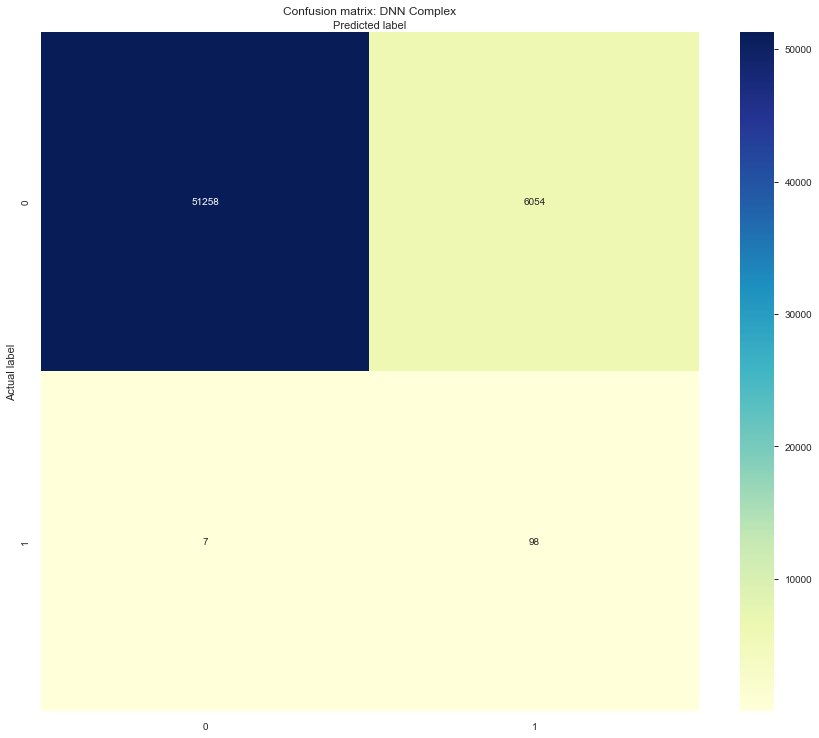

  No Skill : ROC AUC=0.500
DNN-Complex : ROC AUC=0.964


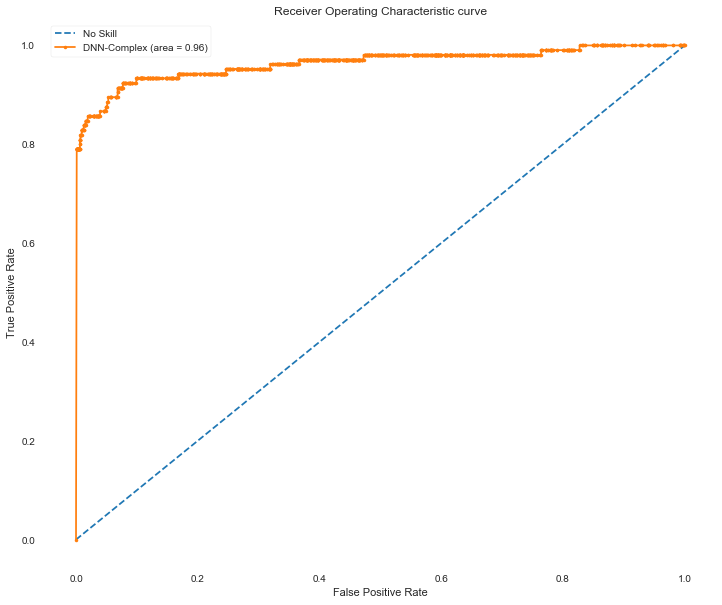

In [99]:
clf = create_dnn_complex(input_dim)
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
clf.fit(X_train, y_train, batch_size=16, epochs=32, 
       verbose=verbose, sample_weight=np.where(y_train == 1,4.0,1.0).flatten(),
       #callbacks=[early_stopping],
       validation_data=(X_val, y_val))
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN complex)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN Complex')
visualize(y_test, yhat_classes, 'DNN Complex')
dnn_complex_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN-Complex')
metrics_results['dnn_complex'] = dnn_complex_auc

In [100]:
a=''''scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)'''

In [101]:
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


0: 0.10016871005500935 1: 296.8664495114007
initial_bias: [-6.38474387]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 200, 'learning_rate': 0.01, 'loss_function': 'Logloss', 'random_seed': 0, 'use_best_model': True, 'class_weights': {0: 0.10016871005500935, 1: 296.8664495114007}, 'random_strength': 1.0, 'custom_loss': ['AUC'], 'eval_metric': 'Logloss', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'subsample': 0.76, 'mvs_reg': 0.0, 'max_depth': 6, 'boost_from_average': False}
[[52389  4473]
 [    4    96]]
0.9214037428461079
Accuracy score (training): 0.922
Accuracy score (validation): 0.921
error
Confusion Matrix:
false positive pct: 7.852603490045995
tn  fp  fn  tp
52389 4473 4 96
[[52389  4473]
 [    4    96]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56862
           1       0.02      0.96      0.04       100

    accuracy                           0.92     56962
   macro avg       0.51      0.94      0.50     56962
weighted avg       1.

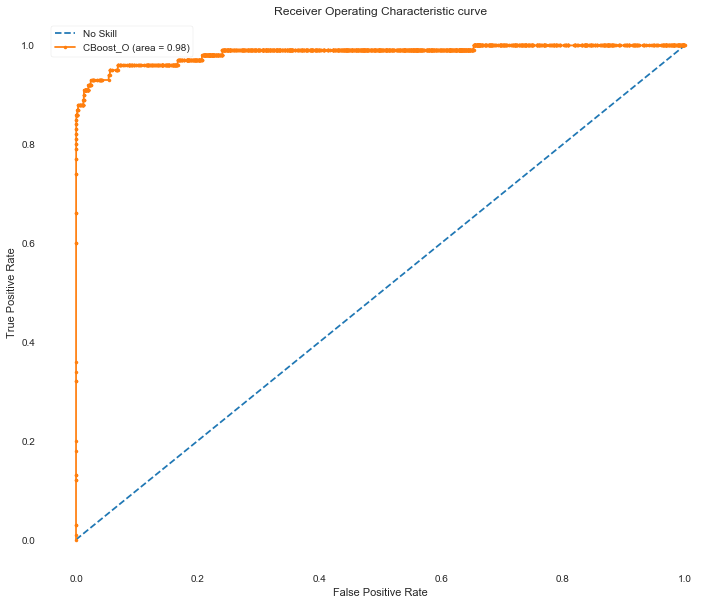

In [132]:
neg, pos = np.bincount(train_labels)
total = neg + pos
initial_bias = np.log([pos/neg])

weight_for_0 = (1 / neg)*(total)/5.0 # was 5
weight_for_1 = (1 / pos)*(total)/2.0 # was 2

#weight_for_0 = 1
#weight_for_1 = neg/pos


class_weight = {0: weight_for_0, 1: weight_for_1}
print('0:', weight_for_0, '1:', weight_for_1)
initial_bias = 1.0 * initial_bias
print('initial_bias:', initial_bias)

clf = CatBoostClassifier(
    iterations=200, 
    learning_rate=0.01, 
    class_weights=class_weight,
    eval_metric='Logloss', # Logloss is default
    random_seed=0,
    custom_loss=['AUC'],
    loss_function='Logloss',
    bootstrap_type='MVS', # can try Bayesian, could be better
    subsample=0.76,
    mvs_reg=0.0,
    random_strength=1.0,
    use_best_model=True,
    max_depth=6,
    boosting_type='Ordered', # Plain
    boost_from_average=False,
    #l2_leaf_reg=0.1, # any reg decreases score
    #loss_function='CrossEntropy'
)
clf.set_scale_and_bias(1.0, initial_bias)

clf.fit(train_features, train_labels, 
        #cat_features=cat_features, 
        eval_set=(val_features, val_labels), 
        verbose=False,
        plot=True,
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())
yhat_classes = clf.predict(test_features, verbose=verbose, prediction_type='Class')
print(metrics.confusion_matrix(test_labels, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, train_features, test_features, train_labels, test_labels, yhat_classes, 'CBoost_O')
dnn_weighted_auc = auc_roc_metrics(clf, test_features, test_labels, 'CBoost_O')
metrics_results['cb_ordered'] = dnn_weighted_auc

0: 0.2003374201100187 1: 296.8664495114007
initial_bias: [-6.38474387]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 200, 'learning_rate': 0.01, 'loss_function': 'Logloss', 'random_seed': 0, 'use_best_model': True, 'class_weights': {0: 0.2003374201100187, 1: 296.8664495114007}, 'random_strength': 1.0, 'custom_loss': ['AUC'], 'eval_metric': 'Logloss', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'subsample': 0.76, 'mvs_reg': 0.0, 'max_depth': 6, 'boost_from_average': False}
[[56041   821]
 [    9    91]]
0.9854288824128367
Accuracy score (training): 0.986
Accuracy score (validation): 0.985
error
Confusion Matrix:
false positive pct: 1.4413117516941119
tn  fp  fn  tp
56041 821 9 91
[[56041   821]
 [    9    91]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56862
           1       0.10      0.91      0.18       100

    accuracy                           0.99     56962
   macro avg       0.55      0.95      0.59     56962
weighted avg       1.00 

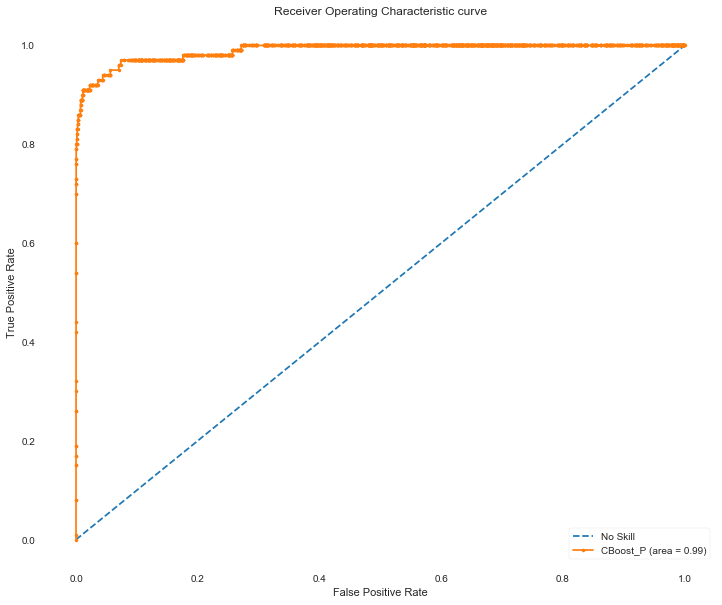

In [103]:
neg, pos = np.bincount(train_labels)
total = neg + pos
initial_bias = np.log([pos/neg])

weight_for_0 = (1 / neg)*(total)/5.0 
weight_for_1 = (1 / pos)*(total)/2.0

#weight_for_0 = 1
#weight_for_1 = neg/pos


class_weight = {0: weight_for_0, 1: weight_for_1}
print('0:', weight_for_0, '1:', weight_for_1)
initial_bias = 1.0 * initial_bias
print('initial_bias:', initial_bias)

clf = CatBoostClassifier(
    iterations=200, 
    learning_rate=0.01, 
    class_weights=class_weight,
    eval_metric='Logloss', # Logloss is default
    random_seed=0,
    custom_loss=['AUC'],
    loss_function='Logloss',
    bootstrap_type='MVS', # can try Bayesian, could be better
    subsample=0.76,
    mvs_reg=0.0,
    random_strength=1.0,
    use_best_model=True,
    max_depth=6,
    boosting_type='Plain', # Plain
    boost_from_average=False,
    #l2_leaf_reg=0.1, # any reg decreases score
    #loss_function='CrossEntropy'
)
#clf.set_scale_and_bias(1.0, initial_bias)

clf.fit(train_features, train_labels, 
        #cat_features=cat_features, 
        eval_set=(val_features, val_labels), 
        verbose=False,
        plot=True,
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())
yhat_classes = clf.predict(test_features, verbose=verbose, prediction_type='Class')
print(metrics.confusion_matrix(test_labels, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, train_features, test_features, train_labels, test_labels, yhat_classes, 'CBoost_P')
dnn_weighted_auc = auc_roc_metrics(clf, test_features, test_labels, 'CBoost_P')
metrics_results['cb_plain'] = dnn_weighted_auc

In [104]:
#import keras.backend as K
def custom_loss(y_true, y_pred):
    #loss = abs(y_true - y_pred)                                                                                   
    mask1 = K.less(y_pred, y_true) # is y_pred < y_true or y_pred - y_true < 0, FN                                 
    mask2 = K.less(y_true, y_pred) # is y_true < y_pred or y_true - y_pred < 0, FP                                 
    #loss = K.cast(mask1, K.floatx()) * 2 * (y_true - y_pred) # only include FN                                    
    loss = (K.cast(mask1, K.floatx()) * 2 * (y_true - y_pred)) + (K.cast(mask2, K.floatx()) * 4 * (y_pred - y_true) ) # FP has higher penalty                                                                                          
    return loss 

def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)

def custom_loss_function(y_true, y_pred):
    squared_difference = K.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

def specificity(y_pred, y_true):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity


In [105]:
# define variable learning rate function
from keras.callbacks import LearningRateScheduler, EarlyStopping, History, LambdaCallback
import math

def step_decay(epoch, lr):
    drop = 0.999 # was .999
    epochs_drop = 50.0 # was 175, sgd likes 200+, adam likes 100
    lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    #print("epoch=" + str(epoch) + " lr=" + str(lr) + " lrate=" + str(lrate))
    return lrate

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, mode='auto', restore_best_weights = True)
callbacks_list = [lrate, early_stopping]  

In [106]:
def make_model(metrics = METRICS, output_bias=-100, opt_sel='adam'):
    #if output_bias is not None:
    print('func_output_bias:', output_bias)
    
    METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
          #keras.metrics.BinaryCrossentropy(name='crossentropy', from_logits=False, label_smoothing=0),
          keras.metrics.BinaryCrossentropy(name='crossentropy'),
          keras.metrics.SensitivityAtSpecificity(specificity=0.0, num_thresholds=200, name='sensitivity'),  # (tp / (tp + fn)).
          keras.metrics.SpecificityAtSensitivity(sensitivity=0.0, num_thresholds=200, name='specificity'),   # (tn / (tn + fp)).
          keras.metrics.CosineSimilarity(name='cosine_similarity', axis=-1),
          keras.metrics.KLDivergence(name='kl_divergence'),
          #custom_loss_mask,
          #custom_loss_function
    ]

    if (output_bias > -50):
        print("output_bias passed in:", output_bias)
        use_bias_sel = True
        output_bias = keras.initializers.Constant(output_bias)
        clf = Sequential([
                Dense(units=16, activation='relu', input_shape=(train_features.shape[-1],)),
                Dropout(0.50),
                Dense(units=1, activation='sigmoid', use_bias=use_bias_sel, bias_initializer=output_bias),
            ])
    else:
        print("output_bias not passed in")
        use_bias_sel = False
        clf = Sequential([
                Dense(units=16, activation='relu', input_shape=(train_features.shape[-1],)),
                Dropout(0.50),
                Dense(units=1, activation='sigmoid'),
            ])

    learning_rate = 0.001
    decay = 0.0002
    momentum=0.99
    #opt_sel = "adam"
    if (opt_sel == "adam"):
        #opt = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, amsgrad=amsgrad) # added to v86
        opt = Adam(lr=learning_rate)
    elif(opt_sel == "sgd"):
        opt = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay, nesterov=True)
    
    clf.compile(
        #optimizer=keras.optimizers.Adam(lr=1e-3),
        optimizer=opt,
        loss=keras.losses.BinaryCrossentropy(),
        #loss=custom_loss_mask,
        #loss=custom_loss_function,
        metrics=METRICS)

    return clf;

In [107]:
# use model from imbalanced_data notebook

BATCH_SIZE = 2048
EPOCHS = 100
neg, pos = np.bincount(train_labels)
total = neg + pos
initial_bias = np.log([pos/neg])
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print('initial_bias:', initial_bias)
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1));

initial_bias: [-6.38474387]
Weight for class 0: 0.50
Weight for class 1: 296.87


In [108]:
# for dnn model with weights and initial bias
def RunModel(mon='val_auc', mod='max', opt_sel='adam'):
    #First Pass
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=mon, verbose=0, patience=25, mode=mod, restore_best_weights=True)

    clf = make_model(output_bias = initial_bias, opt_sel=opt_sel)
    
    clf.fit(
        train_features,
        train_labels,
        initial_epoch=0,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = [early_stopping],
        #callbacks = callbacks_list,
        validation_data=(val_features, val_labels),
        shuffle=False,
        verbose=0,
        # The class weights go here
        class_weight=class_weight
    ) 
    
    #clf.fit(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)#, shuffle=False)
    
    #evaluate does not change or train the model, think this can be skipped unless we want the loss metric
    results = clf.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
    print("Loss: {:0.4f}".format(results[0]))

    # 12/18 before removing these 4 lines
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    clf.save_weights(initial_weights)

    #clf = make_model()
    clf = make_model(output_bias = initial_bias, opt_sel=opt_sel)
    clf.load_weights(initial_weights)

    weighted_history = clf.fit(
        train_features,
        train_labels,
        initial_epoch=0,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = [early_stopping],
        #callbacks = callbacks_list,
        validation_data=(val_features, val_labels),
        shuffle=False,
        verbose=0,
        # The class weights go here
        class_weight=class_weight
    ) 

    yhat_classes = clf.predict_classes(test_features, verbose=verbose, batch_size=BATCH_SIZE)
    yhat_classes = yhat_classes[:, 0]
    print("mon='", mon, "',mod='", mod)
    print(metrics.confusion_matrix(test_labels, yhat_classes))
    tn, fp, fn, tp = display_metrics(clf, train_features, test_features, train_labels, test_labels, yhat_classes, 'DNN Wt '+opt_sel)
    dnn_weighted_auc = auc_roc_metrics(clf, test_features, test_labels, 'DNN Wt '+opt_sel)
    metrics_results['dnn_wt_'+opt_sel] = dnn_weighted_auc
    return (weighted_history);

func_output_bias: [-6.38474387]
output_bias passed in: [-6.38474387]
Loss: 0.0704
func_output_bias: [-6.38474387]
output_bias passed in: [-6.38474387]
56962/56962 [==============================] - 0s 1us/step
mon=' val_auc ',mod=' max
[[56040   822]
 [    9    91]]
error
error
Confusion Matrix:
false positive pct: 1.4430673080299148
tn  fp  fn  tp
56040 822 9 91
[[56040   822]
 [    9    91]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56862
           1       0.10      0.91      0.18       100

    accuracy                           0.99     56962
   macro avg       0.55      0.95      0.59     56962
weighted avg       1.00      0.99      0.99     56962

Specificity = 0.9855439485069115
Sensitivity = 0.91
SS Avg = 0.9477719742534558
DNN Wt adam:TEST | AUC Score: 0.975
  No Skill : ROC AUC=0.500
DNN Wt adam : ROC AUC=0.975


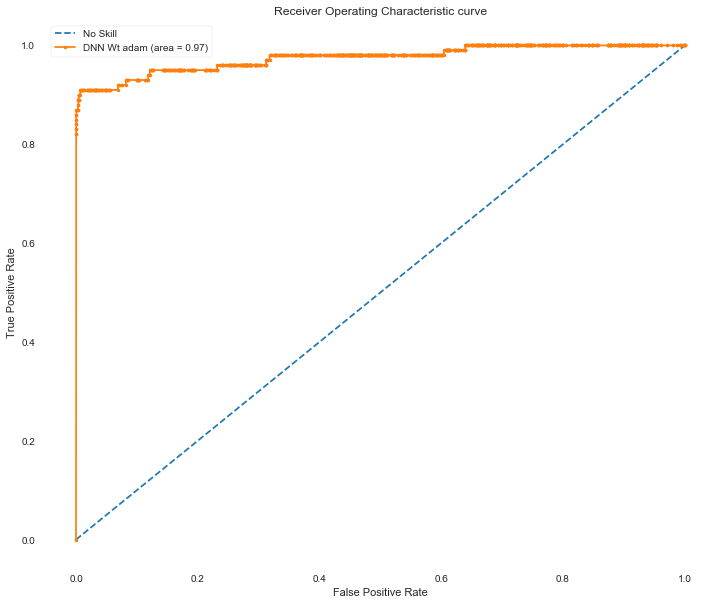

The function took 439.6372957229614 seconds to complete


In [109]:
with MyTimer():
    #weighted_history = RunModel(mon='val_loss', mod='min');
    weighted_history = RunModel(mon='val_auc', mod='max', opt_sel='adam');

func_output_bias: [-6.38474387]
output_bias passed in: [-6.38474387]
Loss: 0.0842
func_output_bias: [-6.38474387]
output_bias passed in: [-6.38474387]
56962/56962 [==============================] - 0s 2us/step
mon=' val_auc ',mod=' max
[[55855  1007]
 [   10    90]]
error
error
Confusion Matrix:
false positive pct: 1.7678452301534358
tn  fp  fn  tp
55855 1007 10 90
[[55855  1007]
 [   10    90]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56862
           1       0.08      0.90      0.15       100

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962

Specificity = 0.9822904575990996
Sensitivity = 0.9
SS Avg = 0.9411452287995499
DNN Wt sgd:TEST | AUC Score: 0.982
  No Skill : ROC AUC=0.500
DNN Wt sgd : ROC AUC=0.982


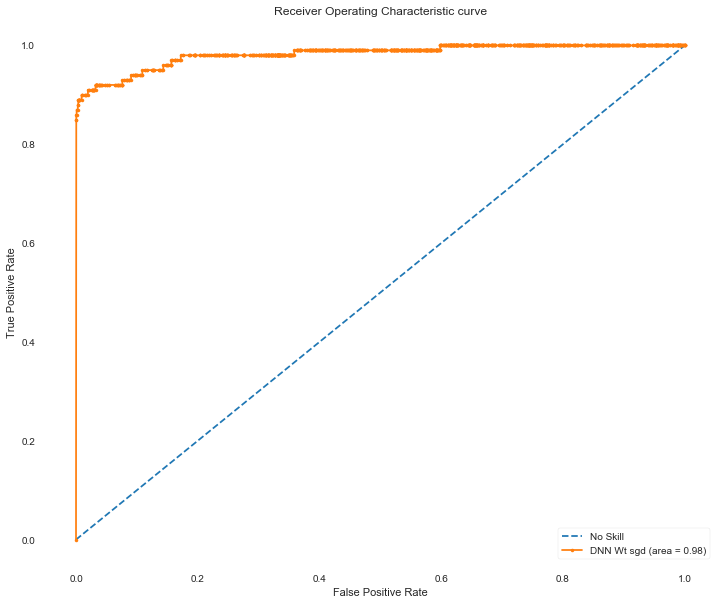

The function took 236.2039544582367 seconds to complete


In [110]:
with MyTimer():
    #weighted_history = RunModel(mon='val_loss', mod='min');
    weighted_history = RunModel(mon='val_auc', mod='max', opt_sel='sgd');

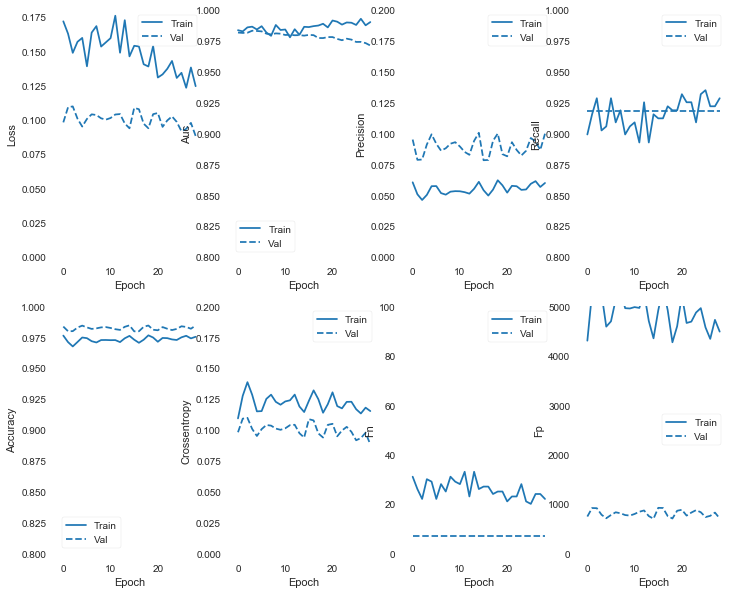

In [111]:
plot_metrics(weighted_history)

In [112]:
cm_results

[['LR', 55227, 2085, 8, 97],
 ['RF', 55716, 1596, 9, 96],
 ['RF2', 55803, 1509, 9, 96],
 ['GB', 56108, 1204, 10, 95],
 ['GB1 Train **', 53063, 4249, 8, 97],
 ['GB2 Train **', 0, 4249, 0, 97],
 ['GB1 Validate **', 41682, 3360, 3, 69],
 ['GB2 Validate **', 0, 3360, 0, 69],
 ['2-Step', 41682, 3360, 3, 69],
 ['2-Step_2nd', 41682, 3360, 3, 69],
 ['CNN', 56465, 847, 14, 91],
 ['DNN', 56959, 353, 13, 92],
 ['DNN Simple', 54797, 2515, 8, 97],
 ['DNN Online', 54797, 2515, 8, 97],
 ['DNN Complex', 51258, 6054, 7, 98],
 ['CBoost_O', 55259, 1603, 6, 94],
 ['CBoost_P', 56041, 821, 9, 91],
 ['DNN Wt adam', 56040, 822, 9, 91],
 ['DNN Wt sgd', 55855, 1007, 10, 90]]

In [113]:
def create_autoencoder(input_dim):
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=15, kernel_initializer='uniform', input_dim=input_dim, activation='tanh', activity_regularizer=regularizers.l1(10e-5)),
        Dense(units=7, kernel_initializer='uniform', activation='relu'),
        Dense(units=7, kernel_initializer='uniform', activation='tanh'),
        Dense(units=31, kernel_initializer='uniform', activation='relu'),
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [114]:
# show all variables in memory
#%who or %whos

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 15)                450       
_________________________________________________________________
dense_32 (Dense)             (None, 7)                 112       
_________________________________________________________________
dense_33 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_34 (Dense)             (None, 31)                248       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 32        
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________
Train on 630 samples, validate on 45114 samples
Epoch 1/32
630/630 [==============================] - 2s 4ms/step - loss:

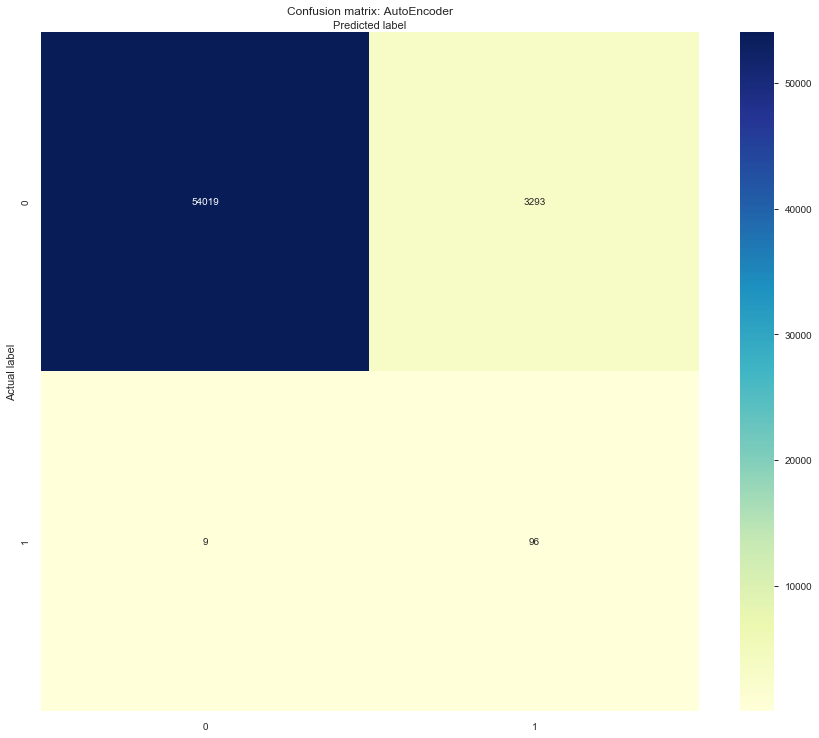

  No Skill : ROC AUC=0.500
AutoEncoder : ROC AUC=0.956


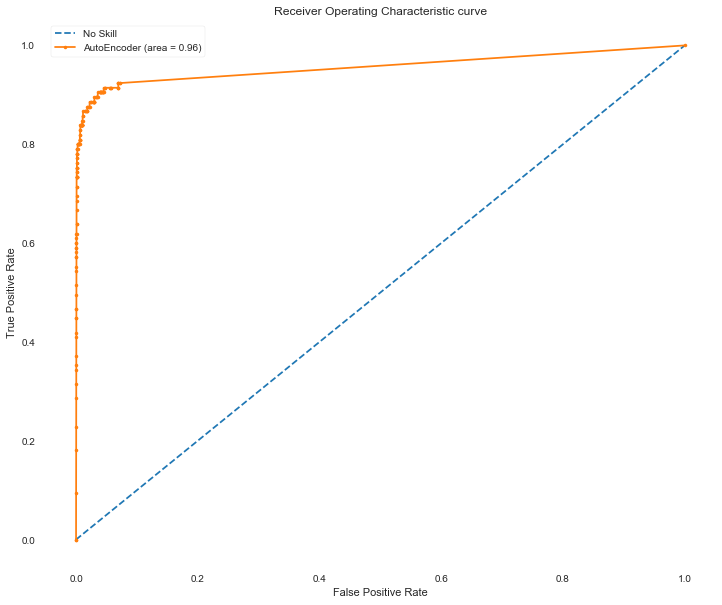

In [115]:
clf = create_autoencoder(input_dim)
clf.summary()
#clf.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=32, epochs=32, shuffle=True)#, validation_data=(X_test, X_test))
clf.fit(X_train, y_train, batch_size=16, epochs=32, verbose=verbose, sample_weight=np.where(y_train == 1,2.0,1.0).flatten(), 
        callbacks=callbacks_list, validation_data=(X_val, y_val))
#clf.fit(X_train, y_train, batch_size=32, epochs=32, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=32)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=32)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (AutoEncoder)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'AutoEncoder')
visualize(y_test, yhat_classes, 'AutoEncoder')
autoencoder_auc = auc_roc_metrics(clf, X_test, y_test, 'AutoEncoder')
metrics_results['autoencoder'] = autoencoder_auc

In [116]:
print("AUC comparisons")
print(metrics_results)

AUC comparisons
{'lr': 0.967, 'rf': 0.984, 'rf2': 0.979, 'gb': 0.977, 'gb1_train': 0.974, 'gb2_train': 0.959, 'gb1_validate': 0.989, 'gb2_validate': 0.983, '2-step': 0.991, 'cnn': 0.972, 'dnn': 0.928, 'dnn_simple': 0.973, 'dnn_online': 0.971, 'dnn_complex': 0.964, 'cb_ordered': 0.987, 'cb_plain': 0.989, 'dnn_wt_adam': 0.975, 'dnn_wt_sgd': 0.982, 'autoencoder': 0.956}


<pre>
AUC comparisons between all the models:

{'lr': 0.965, 'rf': 0.975, 'gb': 0.975, 'gb1_train': 0.979, 'gb2_train': 0.967, 'gb1_validate': 0.99, 'gb2_validate': 0.974, '2-step': 0.941, 'dnn': 0.964, 'dnn_simple': 0.978, 'dnn_complex': 0.939, 'autoencoder': 0.956}
{'lr': 0.968, 'rf': 0.979, 'gb': 0.976, 'gb1_train': 0.975, 'gb2_train': 0.968, 'gb1_validate': 0.991, 'gb2_validate': 0.978, '2-step': 0.957, 'dnn': 0.983, 'dnn_simple': 0.981, 'dnn_complex': 0.961, 'autoencoder': 0.952}

Side by Side comparisions of all models


    LR
    [[64954  3280]
     [   15   104]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.95      0.98     68234
               1       0.03      0.87      0.06       119

        accuracy                           0.95     68353
       macro avg       0.52      0.91      0.52     68353
    weighted avg       1.00      0.95      0.97     68353


    RF
    [[66254  1980]
     [   13   106]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.97      0.99     68234
               1       0.05      0.89      0.10       119

        accuracy                           0.97     68353
       macro avg       0.53      0.93      0.54     68353
    weighted avg       1.00      0.97      0.98     68353


    GB
    [[66732  1502]
     [   16   103]]
    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.98      0.99     68234
               1       0.06      0.87      0.12       119

        accuracy                           0.98     68353
       macro avg       0.53      0.92      0.55     68353
    weighted avg       1.00      0.98      0.99     68353


    2Step
    [[45336  162]
     [   5    67]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.99      0.99     45377
               1       0.36      0.93      0.52        72
        accuracy                           0.??     45449
       macro avg       0.57      0.96      0.71     45449
    weighted avg       1.00      0.99      0.99     45449


    DNN
    [[64991  3243]
     [    9   110]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.95      0.98     68234
               1       0.03      0.92      0.06       119

        accuracy                           0.95     68353
       macro avg       0.52      0.94      0.52     68353
    weighted avg       1.00      0.95      0.97     68353


    DNN Simple
    [[63011  5223]
     [    6   113]]

    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.92      0.96     68234
               1       0.02      0.95      0.04       119

        accuracy                           0.92     68353
       macro avg       0.51      0.94      0.50     68353
    weighted avg       1.00      0.92      0.96     68353


    AutoEncoder
    60277 7957 7 112
    [[60277  7957]
     [    7   112]]
    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.88      0.94     68234
               1       0.01      0.94      0.03       119

        accuracy                           0.88     68353
       macro avg       0.51      0.91      0.48     68353
    weighted avg       1.00      0.88      0.94     68353
    
    
    CNN
    [[64761  3473]
     [   14   105]]
    Classification Report
                  precision    recall  f1-score   support

               0       1.00      0.95      0.97     68234
               1       0.03      0.88      0.06       119

        accuracy                           0.95     68353
       macro avg       0.51      0.92      0.52     68353
    weighted avg       1.00      0.95      0.97     68353




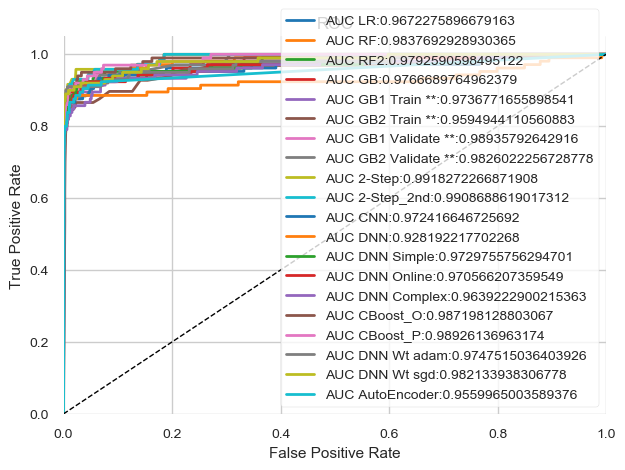

In [117]:
plt.figure(figsize=(7,5),dpi=100)

for i in range(0,len(roc)):
    #print('roc[0]', roc[0])
    #print('roc[i]', roc[i])
    auc1 = auc(roc[i][1],roc[i][2])
    plt.plot(roc[i][1],roc[i][2], label="AUC {0}:{1}".format(roc[i][0], auc1), linewidth=2)
    
plt.plot([0, 1], [0, 1], 'k--', lw=1) 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate') 
plt.title('ROC') 
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

Final confusion matrix results comparing the different algorithms. The items marked with ** are interim results for the 2 step process, and are not for comparison, only shown for reference. As you can see, both the FP and FN values are best for the 2 step process. This process is the most efficient at finding fraudulent transactions, and has the least amount of noise (FP).

number of Actual 0 and 1 in the final validation dataset for 2-test model
"1" total should match the FN + TP

In [118]:
y_val['Class'].value_counts()

0    45042
1       72
Name: Class, dtype: int64

number of Actual 0 and 1 in the final test dataset for all other models
"1" total should match the FN + TP

In [119]:
y_test['Class'].value_counts()

0    57312
1      105
Name: Class, dtype: int64

Here are the final results in tabular form. 

In [120]:
final_results = pd.DataFrame(cm_results, columns=('algo','TN','FP','FN','TP')) 
#sp = round((tn1 + tn2)/(tn1 + tn2 +fp2), 3)
#se = round(tp2/(tp2 + fn1 + fn2), 3)
final_results['SP'] = round(final_results['TN']/(final_results['TN'] + final_results['FP']), 3)
final_results['SE'] = round(final_results['TP']/(final_results['TP'] + final_results['FN']), 3)
final_results['Avg'] = (final_results['SP'] + final_results['SE'])/2
print('test, val, split settings')
print(spl1,spl2)
print('test, val, split sizes')
print( (spl1-spl1*spl2), (spl1*spl2) )
filtered = final_results[~final_results.algo.str.contains('\*', regex= True, na=False)]
sort = filtered.sort_values(filtered.columns[7], ascending = False)
print(sort)
sort.to_csv('c:\\DataScience\\Repo\\Imbalanced_data\\CreditCardFraud\\working\\results.csv', sep=',', mode='a', encoding='utf-8', header=True)


test, val, split settings
0.36 0.44
test, val, split sizes
0.2016 0.15839999999999999
           algo     TN    FP  FN  TP     SP     SE     Avg
15     CBoost_O  55259  1603   6  94  0.972  0.940  0.9560
16     CBoost_P  56041   821   9  91  0.986  0.910  0.9480
17  DNN Wt adam  56040   822   9  91  0.986  0.910  0.9480
0            LR  55227  2085   8  97  0.964  0.924  0.9440
2           RF2  55803  1509   9  96  0.974  0.914  0.9440
1            RF  55716  1596   9  96  0.972  0.914  0.9430
3            GB  56108  1204  10  95  0.979  0.905  0.9420
8        2-Step  41682  3360   3  69  0.925  0.958  0.9415
9    2-Step_2nd  41682  3360   3  69  0.925  0.958  0.9415
18   DNN Wt sgd  55855  1007  10  90  0.982  0.900  0.9410
12   DNN Simple  54797  2515   8  97  0.956  0.924  0.9400
13   DNN Online  54797  2515   8  97  0.956  0.924  0.9400
11          DNN  56959   353  13  92  0.994  0.876  0.9350
19  AutoEncoder  54019  3293   9  96  0.943  0.914  0.9285
10          CNN  56465   847 

In [121]:
print('mean(Avg):', filtered['Avg'].mean())
# power transform settings, not used
#print(pt.get_params())

mean(Avg): 0.9395


In [122]:
f = open('c:\\DataScience\\Repo\\Imbalanced_data\\CreditCardFraud\\working\\averages.txt', 'a+')
f.write(str(filtered['Avg'].mean()))
f.write("\n")
f.close()

In [123]:
print("Start: ", StartTime)
print("End: ", datetime.datetime.now())

Start:  2020-09-29 11:12:11.257301
End:  2020-09-29 11:44:25.968295


things to try, calculate optimal weights

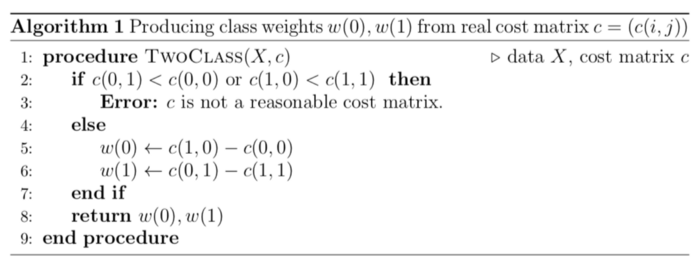

reference: https://medium.com/rv-data/how-to-do-cost-sensitive-learning-61848bf4f5e7

v4 - optimize GB for 2-Step

use other models for 2-Step model, instead of GB. LR first

In [124]:
# loading model that was saved in another script
#clf = keras.models.load_model("sampled_model")

OSError: Unable to open file (unable to open file: name = 'sampled_model', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
%%javascript
Jupyter.notebook.session.delete();